# CE811 Assignment 2

# Can Stacked Genetic Algorithms Following Stacked Rules Stack Cards Following Stacking Rules?

In this notebook, I shall attempt to compare the performance of a variety of genetic algorithm
chromosome types for controlling the behaviour of an agent playing *Hanabi* with 3 copies of itself,
with the aim of seeing which variety of chromosome controller is the most effective,
and the aim of seeing what

In [1]:
# But first, a word from our sponsors.
# And by that, I mean 'heres a bunch of imports have fun'
import collections
import concurrent.futures
import dataclasses
import multiprocessing
import random
from typing import NamedTuple, Sequence, Final, Sized, Protocol, TypedDict, Generic, Literal, Set, Union, List, NoReturn, TypeVar, Tuple, Generator, FrozenSet, Callable, Iterable, Any, Dict, Iterator, Type, Optional
from enum import Enum, auto, IntFlag, Flag, EnumMeta
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
import numpy as np
import scipy as sp
from scipy import signal
import math
import hanabi_learning_environment
from hanabi_learning_environment import rl_env
from hanabi_learning_environment.rl_env import Agent
from itertools import chain
from numpy.random import default_rng
import json
import scipy as sp
import abc
import functools
import itertools
import warnings
import pprint
from dataclasses import dataclass
from collections import defaultdict
import queue
from collections import deque

from concurrent.futures import ThreadPoolExecutor
from multiprocessing import set_start_method, get_context

#try:
#    set_start_method("spawn")
#except RuntimeError:
#    pass # le shrug


rng: np.random.Generator = default_rng()


In [2]:
# And now time for another word from our other sponsors.
# By which I mean 'here are a bunch of type annotations for the sake
# of making it easier for me to use the hanabi-learning-environment'

# Yes, I know, I spelt 'Colour' as 'Color' here.
# This is mostly because the Hanabi Learning Environment
# contains the word 'color' quite a bit, and I figured that
# consistent spelling of that within the code would save
# a few headaches later on.

Color: Type = Literal["B", "G", "R", "W", "Y"]
CardColor: Type = Optional[Color]
Rank: Type = Literal[0, 1, 2, 3, 4]
CardRank: Type = Literal[-1, Rank]

ActionPD: Type = Literal["PLAY", "DISCARD"]
ActionColor: Type = Literal["REVEAL_COLOR"]
ActionRank: Type = Literal["REVEAL_RANK"]


class BaseActionDict(TypedDict):
    pass

class ActionPDDict(BaseActionDict):
    action_type: ActionPD
    card_index: int

def actplay(ind: int) -> ActionPDDict:
    """
    Helper method to create the appropriate dict for playing a card
    :param ind: index of card to play
    :return: an actionPDDict that plays that specified card
    """
    return {
        "action_type": "PLAY",
        "card_index": ind
    }

def actdiscard(ind: int) -> ActionPDDict:
    """
    Helper method for discarding
    :param ind: index of card being discarded
    :return: the appropriate actionPDDict
    """
    return {
        "action_type": "DISCARD",
        "card_index": ind
    }

class BaseActionRevealDict(BaseActionDict):
    target_offset: int

class ActionColorDict(BaseActionRevealDict):
    action_type: ActionColor
    color: Color

def actcolor(offset: Union[int, "OtherPlayerData"], colour: Color) -> ActionColorDict:
    """
    Helper method for revealing colour
    :param offset: player to target
    :param colour: colour to reveal
    :return: the appropriate ActionColorDict
    """
    if isinstance(offset, OtherPlayerData):
        offset = offset.offset
    return {
        "action_type": "REVEAL_COLOR",
        "color": colour,
        "target_offset": offset
    }

class ActionRankDict(BaseActionRevealDict):
    action_type: ActionRank
    rank: Rank

def actrank(offset: Union[int, "OtherPlayerData"], rank: Rank) -> ActionRankDict:
    """
    Helper method for revealing rank
    :param offset: player to target
    :param rank: rank to reveal
    :return: the appropriate ActionRankDict
    """
    if isinstance(offset, OtherPlayerData):
        offset = offset.offset
    return {
        "action_type": "REVEAL_RANK",
        "rank": rank,
        "target_offset": offset
    }

ActionReveal = Union[ActionColorDict, ActionRankDict]
ActionDict = Union[ActionPDDict, ActionReveal]
Action = Union[ActionDict, int]

class HandCard(TypedDict):
    color: CardColor
    rank: CardRank

OwnHand = List[HandCard]

class KnownCard(TypedDict):
    color: Color
    rank: Rank


KnownHand = List[KnownCard]

Card = Union[HandCard, KnownCard]

class FireworksDict(TypedDict):
    B: int
    G: int
    R: int
    W: int
    Y: int

FRank = Literal[0,1,2,3,4,5]

class Playability(IntFlag):
    PLAYABLE = auto()
    "Indicates that a card is playable right now"
    FUTURE = auto()
    "Indicates that a card may be playable in the future"
    UNKNOWN = auto()
    "indicates that we have no idea what this card is"
    USELESS = auto()
    "indicates that this card is useless, and is discard fodder."

    # only one unique instance visible
    ONE_VISIBLE = auto()
    """
    These values are here to indicate cards where only one
    instance of them is visible as of right now.
    """
    PLAYABLE_1 = PLAYABLE | ONE_VISIBLE
    FUTURE_1 = FUTURE | ONE_VISIBLE

    # only one instance not discarded
    ENDANGERED = auto()
    """and this are here to indicate cards where only one
    instance of them is not currently discarded as of
    right now."""
    PLAYABLE_ENDANGERED = PLAYABLE | ENDANGERED
    FUTURE_ENDANGERED   = FUTURE   | ENDANGERED

    SAVEME = ONE_VISIBLE | ENDANGERED
    """And any card that has only one instance visible or one instance left
    is labelled with 'SAVEME', indicating that they need to be saved."""




@dataclass(init=True, repr=True, eq=True, frozen=True)
class FireworksData:
    B: FRank
    G: FRank
    R: FRank
    W: FRank
    Y: FRank

    def __str__(self):
        return f"fireworks- B:{self.B}, G:{self.G}, R:{self.R}, W:{self.W}, Y:{self.Y}"

    @functools.cached_property
    def tupled(self) -> Tuple[FRank, FRank, FRank, FRank, FRank]:
        return dataclasses.astuple(self)

    @functools.cached_property
    def dicted(self) -> Dict[str, FRank]:
        return dataclasses.asdict(self)

    @functools.cached_property
    def legal_playables(self) -> Set["CardData"]:
        legals: Set["CardData"] = set()
        for c, r in self.dicted.items():
            if r < 5:
                legals.add(CardData(c,r))
        return legals


    @functools.cached_property
    def min_play_rank(self) -> FRank:
        return min(self.tupled)

    @functools.cached_property
    def max_play_rank(self) -> Rank:
        if not self.legal_playables:
            return 5
        else:
            return max(self.legal_playables, key=lambda c: c.rank).rank


    def definite_playability(self, card: "CardData") -> Playability:
        if card.rank == -1:
            if card.color is None:
                return Playability.UNKNOWN
            else:
                if self.dicted[card.color] < 5:
                    return Playability.UNKNOWN
                return Playability.USELESS
        elif card.color is None:
            if self.min_play_rank > card.rank:
                return Playability.USELESS
            return Playability.UNKNOWN
        else:
            nextr: FRank = self.dicted[card.color]
            if nextr > card.rank:
                return Playability.USELESS
            elif nextr == card.rank:
                return Playability.PLAYABLE
            return Playability.FUTURE


    def hand_playability(self, hand: List["CardData"]) -> List[Playability]:
        return [self.definite_playability(c) for c in hand]

    def playability_lookup_dict(self, cards: Iterable["CardData"]) -> Dict["CardData", Playability]:
        """
        Creates a lookup table for the current playability of all the cards in the given
        iterable of cards.
        :param cards: the cards we want to find the playabilities of
        :return: A dict mapping [card, Playability] given the state of this fireworks object
        """
        return dict(
            (crd, self.definite_playability(crd)) for crd in cards
        )



    @classmethod
    def make(cls, fworks: FireworksDict) -> "FireworksData":
        return cls(fworks["B"],fworks["G"],fworks["R"],fworks["W"],fworks["Y"])



@dataclass(init=True, repr=True, eq=True, frozen=True)
class CardData:
    color: CardColor
    rank: CardRank

    @property
    def r_known(self) -> bool:
        return self.rank != -1

    @classmethod
    def make(cls, c: Card) -> "CardData":
        return cls(c["color"],c["rank"])

    @property
    def iter_higher(self) -> Iterator["CardData"]:
        "iterate through all of the cards higher than this card in same colour"
        return (CardData(self.color, rnk) for rnk in range(self.rank +1, 5))

    @property
    def is_known(self) -> bool:
        "returns true if all the data on this card is known"
        return self.color is not None and self.rank != -1

    def match_potential_other_known(self, crd: "CardData") -> bool:
        assert crd.is_known
        if self.is_known:
            return self == crd
        else:
            if self.color:
                return self.color == crd.color
            return self.rank == -1 or self.rank == crd.rank


    def potential_matches(self, other_cards: Iterable["CardData"]) -> Iterator["CardData"]:
        if self.is_known:
            return (crd for crd in other_cards if crd == self)
        return (crd for crd in other_cards if self.match_potential_other_known(crd))
    
UNKNOWN_CARD: CardData = CardData(None, -1)


def card_to_dc(c: Card) -> CardData:
    return CardData(c["color"], c["rank"])

def cardlist_to_dc(clist: Iterable[Card]) -> List[CardData]:
    return [CardData.make(c) for c in clist]

TCard = TypeVar("TCard", bound=Card)




class ObservationDict(TypedDict):
    current_player: int
    current_player_offset: int
    deck_size: int
    discard_pile: List[KnownCard]
    fireworks: FireworksDict
    information_tokens: int
    legal_moves: List[ActionDict]
    life_tokens: int
    card_knowledge: List[OwnHand]
    observed_hands: List[Union[OwnHand, KnownHand]]
    num_players: int
    vectorized: List[Literal[0, 1]]
    pyhanabi: Any


T = TypeVar("T")

def sany(it: Iterable[T]) -> Optional[T]:
    """
    Attempts to return an arbitrary item from an iterable.
    :param it: the iterable we want an arbitrary item from
    :return: the first item from that iterable, or null if it's empty
    """
    an_iter: Iterator[T] = it.__iter__()
    try:
        return an_iter.__next__()
    except StopIteration:
        return None


As mentioned earlier, the aim for this is to find out which
approach to playing Hanabi produces an optimal agent for
playing Hanabi.

And then, this optimal Hanabi agent will have to be tested based
on a set Hanabi agent evaluation environment.

The evaluation environment for the final agent involves
playing a game with 4 players, a hand size of 4,
5 suits of cards with values 0-4 (effectively 1-5 rank but
in an indexable range), and an overall deck size of 50.

Therefore, this agent shall be set up to be able to
comprehend and play this variety of Hanabi.


Here is an enum for the rules that the agent will follow,
along with a class that attempts to play hanabi,
following aforementioned rules,
given as a list of the rule enum items.




In [3]:
class Filterable(EnumMeta):
    @abc.abstractmethod
    def apply_filter(self, fl: Flag) -> bool:
        """
        Sees if this member matches anything with the given flag
        :param f: a filter to match with
        :return: true if anything matches
        """

    @abc.abstractmethod
    def apply_filter_exact(self, fl: Flag) -> bool:
        """
        Sees if this member is an EXACT match for the given flag
        :param f: a filter to match
        :return: true only if there's an EXACT match
        """


class RuleFilter(IntFlag, metaclass=Filterable):
    idc = -1
    "Used to indicate 'I don't care, allow everything'"
    nope = 0
    "A special value to indicate that nothing at all should be allowed."

    TELL = auto()
    "For rules that involve telling someone about their card, needing info tokens"
    DISCARD = auto()
    "For rules that involve discarding, requiring that we haven't reached the info token limit"

    MY_FULL_INFO = auto()
    "For rules that require this agent to know everything about itself"
    WAS_HINTED_LAST_TURN = auto()
    "For rules that require this agent to have received a hint since last turn"

    OTHER_HAS_UNKNOWN_UNIQUE_PLAYABLE_ON_DISCARD = auto()
    "For rules that require another player who has the only visible playable card of that variety on their 'chop'"
    OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD = auto()
    "For rules that require another player to have an unknown, special, not-useless card on their 'chop'"

    OTHER_HAS_UNKNOWN_PLAYABLE_RANK = auto()
    "For rules that require someone else to not know the rank of their playable card"
    OTHER_HAS_UNKNOWN_PLAYABLE_COLOR = auto()
    "For rules that involve someone else not knowing the colour of their playable card"
    OTHER_HAS_UNKNOWN_ENDANGERED_RANK = auto()
    "For rules that require someone else to not know the rank of their endangered card"
    OTHER_HAS_UNKNOWN_ENDANGERED_COLOR = auto()
    "For rules that involve someone else not knowing the colour of their endangered card"
    OTHER_HAS_UNKNOWN_FUTURE_PLAYABLE = auto()
    "for rules where someone doesn't know that they have a card that'll be playable in the future"
    OTHER_HAS_UNKNOWN_USELESS_RANK = auto()
    "for rules where a player doesn't know the rank of a useless card they have"
    OTHER_HAS_UNKNOWN_USELESS_COLOR = auto()
    "for rules where a player doesn't know the colour of a useless card they have"

    OTHER_HAS_UNKNOWN_USELESS = OTHER_HAS_UNKNOWN_USELESS_RANK | OTHER_HAS_UNKNOWN_USELESS_COLOR
    OTHER_HAS_UNKNOWN_PLAYABLE = OTHER_HAS_UNKNOWN_PLAYABLE_RANK | OTHER_HAS_UNKNOWN_PLAYABLE_COLOR
    "Composite of unknown playable rank and unknown playable colour"
    OTHER_HAS_UNKNOWN_ENDANGERED = OTHER_HAS_UNKNOWN_ENDANGERED_COLOR | OTHER_HAS_UNKNOWN_ENDANGERED_RANK
    "Composite of unknown endangered rank and unknown endangered colour"

    def apply_filter(self, fl: Flag) -> bool:
        return bool(self & fl)

    def apply_filter_exact(self, fl: Flag) -> bool:
        return self == fl


class RulesEnum(Enum, metaclass=Filterable):
    def __new__(
            cls,
            arity: int,
            filter: Optional[RuleFilter] = None
    ) -> "RulesEnum":
        """
        Attempts to create the individual members of this enum.
        :param arity: How many trainable arguments does this rule have?
        :param filter: Are there any special conditions that need
        to be met for this rule to be applied? If None or idc, it's always applicable.
        """
        val: int = len(cls.__members__)
        r: "RulesEnum" = object.__new__(cls)
        r._value_ = val
        r._arity = arity
        if filter is None:
            # if no filter is given, we mark it with 'idc' for 'lets not filter this'
            r._filter = RuleFilter.idc
        else:
            r._filter = filter
        return r

    PLAY_HIGHEST_KNOWN_PLAYABLE = (0, RuleFilter.MY_FULL_INFO)
    "Play the highest card which is known to be playable"
    PLAY_LOWEST_KNOWN_PLAYABLE = (0, RuleFilter.MY_FULL_INFO)
    "Play the lowest card which is known to be playable"
    PLAY_MOST_PLAYABLE_THRESH_9998 = 0
    "Play most playable card as long as it's 99.98% playable"
    PLAY_MOST_PLAYABLE_THRESH_80 = 0
    "Play most playable card as long as it's 80% playable"
    PLAY_MOST_PLAYABLE_THRESH_60 = 0
    "Play most playable card as long as it's 60% playable"
    PLAY_MOST_PLAYABLE_THRESH_40 = 0
    "40%"
    PLAY_MOST_PLAYABLE_THRESH_20 = 0
    "20%"
    PLAY_MOST_PLAYABLE_THRESH_A = 1
    "Plays most playable card, as long as its playability is above a TRAINABLE threshold"
    PLAY_MOST_PLAYABLE_THRESH_B = 1
    "Plays most playable card, as long as its playability is above a(nother) TRAINABLE threshold"
    PLAY_MOST_PLAYABLE_DECK_EMPTY = 0
    "Plays most playable card anyway when the deck is empty"
    PLAY_MOST_PLAYABLE = 0
    "Plays most playable card"

    PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    """Plays the most playable card, which we are least 80% sure is playable,
    that received a hint since our last turn."""
    PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_60 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    "ditto but 60%"
    PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_40 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    "ditto but 40%"
    PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_T = (1, RuleFilter.WAS_HINTED_LAST_TURN)
    """ditto but trainable threshold"""


    PLAY_NEWEST_LAST_HINTED_CARD_80 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    """Plays the newest card, which we are least 80% sure is playable,
    that received a hint since our last turn."""
    PLAY_NEWEST_LAST_HINTED_CARD_60 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    "ditto but 60%"
    PLAY_NEWEST_LAST_HINTED_CARD_40 = (0, RuleFilter.WAS_HINTED_LAST_TURN)
    "ditto but 40%"
    PLAY_NEWEST_LAST_HINTED_CARD_T = (1, RuleFilter.WAS_HINTED_LAST_TURN)
    """ditto but trainable threshold"""



    TELL_ANY_ABOUT_ONES_GT = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """Attempts to tell the next player who has ones that they aren't aware of about the ones they have"""

    TELL_ANY_ABOUT_FIVES_GT = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """
    Attempts to tell the next player who has a 5 on their 'chop' about the fact that they have a 5 on there,
    via 'good touch' rules."""
    TELL_ANY_ABOUT_FIVES_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """Attempts to tell the next player who has fives that they don't know are fives about them
    being fives"""


    TELL_NEXT_PLAYABLE_GOOD_TOUCH = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """If the next player has a playable card (or cards) that they don't know about,
    this will attempt to tell the next player a fact about the card(s) which only involve telling
    them about that playable card(s). Will aim to tell only one fact about them. If player already
    has a playable card that they know something about, this rule won't fire."""

    TELL_ANY_PLAYABLE_GOOD_TOUCH = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """Attempts to tell any player info about an unknown playable card they have"""

    TELL_NEXT_NO_KNOWN_FUTURE_PLAYABLES_GOOD_TOUCH = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_FUTURE_PLAYABLE)
    """If the next player has a playable card they know something about, which, upon being played,
    means that the player after that has card that they don't know anything about that they can play,
    as long as they don't already have a card that they would be able to play after the next player
    plays their known playable card, this will attempt to tell them about that
    playable card via the 'good touch' approach."""

    TELL_NEXT_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
    """If the next player has multiple cards of the same rank,
    all of which being playable, they are told what rank those cards are
    """
    TELL_ANY_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
    """ Attempts to tell the next player who has multiple cards of the same rank,
    all of which being playable, what the rank of those cards are.
    """
    TELL_NEXT_SAVE_UNIQUE_TWO_GT = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """Attempts to tell next player if they do not have a known not-useless card, but has the only visible
    two of that colour on their 'chop', about their twos
    """
    TELL_ANY_SAVE_UNIQUE_TWO_GT = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """Attempts to tell the next player who does not have a known not-useless card, but has the only visible
    two of that colour on their 'chop', about their twos
    """
    TELL_ANY_SAVE_UNIQUE_TWO_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """Ditto, but by simply informing them about twos"""
    TELL_ANY_SAVE_UNIQUE_TWO_COLOR = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """Ditto, but by simply informing the about the colour of the two"""

    TELL_NEXT_UNIQUE_PLAYABLE_GOOD_TOUCH = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
    """If the next player has the only visible copy of a playable card, we tell them about that card"""




    TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK)
    """Tells next player with a useless card that has a rank below the current rank for
    every colour what the rank of that useless card is."""
    TELL_ANY_USELESS_CARD_HALF_INFO = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_USELESS)
    """Tells next player, who knows half of the info about their useless card,
    the other half of the info about their useless card"""

    TELL_ANY_ENDANGERED_CARD_HALF_INFO = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
    """Tells next player who has an endangered card that they know half of the info about
    the rest of the info about that card"""
    TELL_ANY_ENDANGERED_CARD_RANK = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK)
    """Tells next player the rank of their endangered card that they don't know the rank of"""
    TELL_ANY_ENDANGERED_CARD_COLOR = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR)
    """Tells next player the colour of their endangered card that they don't know the colour of"""
    TELL_ANY_ENDANGERED_CARD_GT = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
    TELL_ANY_ENDANGERED_CARD_ANY = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
    """Tells next player an abitrary fact about their endangered card"""

    TELL_NEXT_SAVE_GT= (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """
    If the next player's oldest unknown card needs saving, and they don't have a known playable card that
    they could just play instead of discarding next turn, we attempt to tell them some info about that card"""
    TELL_NEXT_SAVE_R = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """
    If the next player's oldest unknown card needs saving, and they don't have a known playable card
    that they would be likely to play instead of saving that endangered card, we attempt to tell them
    about that endangered card. This version of the rule attempts to tell them about the rank of it."""

    TELL_NEXT_SAVE_C = (0, RuleFilter.TELL | RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
    """
    If the next player's oldest unknown card needs saving, and they don't have a known playable card
    that they would be likely to play instead of saving that endangered card, we attempt to tell them
    about that endangered card. This version of the rule attempts to tell them about the colour of it,
    but will tell about the rank instead if there's a useless card of that colour in their hand."""


    DISCARD_KNOWN_USELESS_CARD = (0, RuleFilter.DISCARD | RuleFilter.MY_FULL_INFO)
    """Discard a card that we know is useless"""
    DISCARD_KNOWN_DISPOSABLE_CARD = (0, RuleFilter.DISCARD | RuleFilter.MY_FULL_INFO)
    """Discard a card that isn't strictly needed in order to win"""

    DISCARD_MOST_DISPOSABLE_CARD_9998 = (0, RuleFilter.DISCARD)
    """Discard a card that we're 99.98% sure is useless or redundant"""
    DISCARD_MOST_DISPOSABLE_CARD_80 = (0, RuleFilter.DISCARD)
    "Discard a card that we're 80% sure is useless or redundant"
    DISCARD_MOST_DISPOSABLE_CARD_60 = (0, RuleFilter.DISCARD)
    "Discard a card that we're 60% sure is useless or redundant"
    DISCARD_MOST_DISPOSABLE_CARD_40 = (0, RuleFilter.DISCARD)
    "Discard a card that we're 40% sure is useless or redundant"
    DISCARD_MOST_DISPOSABLE_CARD_THRESH_A = (1, RuleFilter.DISCARD)
    """Uses a TRAINABLE threshold to dictate how useless/redundant
    a card needs to be to be considered discardable by this rule"""
    DISCARD_MOST_DISPOSABLE_CARD_THRESH_B = (1, RuleFilter.DISCARD)
    "ditto, but uses a different threshold"

    DISCARD_OLDEST_CARD = (0, RuleFilter.DISCARD)
    "Discards the oldest card (lowest index)"
    DISCARD_OLDEST_UNKNOWN_CARD = (0, RuleFilter.DISCARD)
    "Discards the oldest card (lowest index) we know nothing about."
    DISCARD_LAST_HINTED_CARD_80 = (0, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability of at least 80%,
    that we recieved a hint about last turn"""
    DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 = (0, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability of at least 80%,
    that we previously didn't know anything about last turn."""
    DISCARD_LAST_HINTED_CARD_T = (1, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability from a trainable threshold
    that we recieved a hint about last turn"""
    DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T = (1, RuleFilter.DISCARD | RuleFilter.WAS_HINTED_LAST_TURN)
    """Discard the least playable card, with a disposability from a trainable threshold
    that we previously didn't know anything about last turn."""


    @property
    def arity(self) -> int:
        "How many arguments does this rule have?"
        return self._arity

    @property
    def filter(self) -> RuleFilter:
        "Find the filter conditions for this rule."
        return self._filter

    def apply_filter(self, fl: Flag) -> bool:
        """
        Sees if this rule passes the given filter. This is here so I can avoid wasting time
        on rules that don't pass the given filter
        :param fl: the filter to apply to this _filter
        :return: result of fl & self._filter
        """
        return bool(fl & self._filter)

    def apply_filter_exact(self, fl: Flag) -> bool:
        """
        Apply the given filter EXACTLY.
        :param fl: the filter to match EXACTLY with self._filter
        :return: true if this rule's filterer IS the given filter
        """
        return self._filter == fl

    @classmethod
    def filtered(
            cls,
            members: Optional[List["RulesEnum"]] = None,
            filter_by: Optional[RuleFilter] = None
    ) -> Tuple["RulesEnum",...]:
        """
        Attempts to filter a list of RulesEnum members, only returning a tuple of those members who
        satisfy the given condition
        :param members: the list of RulesEnum members to filter. If None,
        will obtain a view of all of the RulesEnums, and will filter based on that..
        :param filter_by: the condition that must be satisfied for the filtering.
        If not given, or if RuleFilter.idc is given, no filtering will happen.
        :return: A copy of the given list, filtered according to the given filter.
        """
        if members is None:
            members = [*RulesEnum.__members__.values()]
        if (filter_by is None) or (filter_by == RuleFilter.idc):
            return tuple(members)
        return tuple(m for m in members if m.apply_filter(filter_by))


st: str = "q   "
for f in RuleFilter.__members__.values():
    st = f"{st} {f:{3}}"
print(st)
print("")

for r in RulesEnum.__members__.values():
    print(str(r))
    st: str = f"{str(r.apply_filter_exact(RuleFilter.idc))[:1]}   "
    for f in RuleFilter.__members__.values():
        st = f"{st} {str(r.apply_filter(f))[:1]:{3}}"
    print(st)


q     -1   0   1   2   4   8  16  32  64 128 256 512 1024 2048 4096 6144 192 768

RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE
F    T   F   F   F   T   F   F   F   F   F   F   F   F   F   F   F   F   F  
RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE
F    T   F   F   F   T   F   F   F   F   F   F   F   F   F   F   F   F   F  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_9998
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_40
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_20
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T   T  
RulesEnum.PLAY_MOST_PLAYABLE_THRESH_A
T    T   F   T   T   T   T   T   T   T   T   T   T   T   T   T   T   

In [4]:

@dataclass(init=True, repr=True, eq=True, frozen=True)
class ChromosomeInfo:
    """
    A dictionary of information which will be given to each chromosome when
    they're being asked to provide info to the agent. This may or may not be
    used when a chromosome decides which list of rules to give to the agent.
    """
    info_tokens: int
    "How many info tokens are left?"
    lives: int
    "How many lives are left?"
    fireworks: FireworksData
    "What fireworks have been played?"
    deck_left: int
    "How much of the deck is left?"
    player_index: int
    "Which index player is this?"
    has_discarded: bool
    "Have any cards been discarded yet?"




@dataclass(init=True, repr=True, eq=True, frozen=True)
class AgentRules:
    """
    The rules list given by the chromosome to the agents
    """
    rules: Tuple[RulesEnum]
    """
    The ordered list of rules, for the agent to attempt in sequence
    """
    params: Dict[RulesEnum, Union[float,Tuple[float, ...]]] = dataclasses.field(default=dict)
    """
    Parameters for the rules that have trainable parameters will be held
    in here, for ease of lookup.
    """

    @classmethod
    @functools.lru_cache(maxsize=1)
    def agent_default_params(cls) -> Dict[RulesEnum, Union[float,Tuple[float, ...]]]:
        return {
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_9998: 0.9988,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80: 0.8,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60: 0.6,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_40: 0.4,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_20: 0.2,
            RulesEnum.PLAY_MOST_PLAYABLE: 0,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80: 0.8,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_60: 0.6,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_40: 0.4,
            RulesEnum.PLAY_NEWEST_LAST_HINTED_CARD_80: 0.8,
            RulesEnum.PLAY_NEWEST_LAST_HINTED_CARD_60: 0.6,
            RulesEnum.PLAY_NEWEST_LAST_HINTED_CARD_40: 0.4,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_9998: 0.9988,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_80: 0.8,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_60: 0.6,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_40: 0.4,
            RulesEnum.DISCARD_LAST_HINTED_CARD_80: 0.8,
            RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80: 0.8
        }

    def __post_init__(self):
        self.params.update(AgentRules.agent_default_params())



class I_AgentChromosome(abc.ABC):
    """
    An interface for the chromosomes, exposing only the method
    which the agent calls in order to obtain the necessary
    ordered rules/trained parameters it needs for purposes of playing the game.
    """

    @abc.abstractmethod
    def get_rules_and_parameters(self, info: ChromosomeInfo) -> AgentRules:
        """
        Given a ChromosomeInfo object, return the appropriate ordered list of rules,
        along with a dictionary holding the relevant trained parameters for
        the rules that have trained parameters.
        :param info: The info to give to the chromosome, for purposes of choosing
        what ruleset to return
        :return: the appropriate ruleset.
        """
        pass




class OtherPlayerInfo(TypedDict):
    """
    A dict holding some info about the other players.
    p: the offset for this player.
    hand: The cards the player has in their hand.
    playable: indices of playable cards in their hand
    useless: indices of unplayable cards in their hand
    endangered: indices of 'endangered' cards
      (last non-discarded instance of that card)
    ranks: indices of cards with unknown ranks
    cols: indices of cards with unknown colours
    filter: a filter that can be used later on to skip looking at non-relevant players.
    """
    p: int
    hand: List[KnownCard]
    playable: FrozenSet[int]
    useless: FrozenSet[int]
    endangered: FrozenSet[int]
    ranks: FrozenSet[int]
    cols: FrozenSet[int]
    filter: RuleFilter


def f_inds_by_col(cards: List[CardData], col: Color) -> Set[int]:
    c_inds: Set[int] = set()
    for i, crd in enumerate(cards):
        if crd.color == col:
            c_inds.add(i)
    return c_inds


def f_inds_by_rank(cards: List[CardData], ran: Rank) -> Set[int]:
    r_inds: Set[int] = set()
    for i, crd in enumerate(cards):
        if crd.rank == ran:
            r_inds.add(i)
    return r_inds


def f_inds_by_match_c_r(cards: List[CardData], c: CardData) -> Tuple[Set[int], Set[int]]:
    c_inds: Set[int] = set()
    r_inds: Set[int] = set()
    for i, crd in enumerate(cards):
        if crd.color == c.color:
            c_inds.add(i)
        if crd.rank == c.rank:
            r_inds.add(i)
    return c_inds, r_inds



@dataclass(init=True, repr=True, eq=True, frozen=True)
class OtherPlayerData:
    """
    Data obtained about the other players, in a more digestable form
    """
    offset: int
    "player offset"
    hand: List[CardData]
    "cards they have"
    knowledge: List[CardData]
    "what they know"
    playables: FrozenSet[int]
    "indices of their playable cards"
    useless: FrozenSet[int]
    "indices of their useless cards"
    f_playables: FrozenSet[int]
    """Indices of cards which could be played in the future"""
    saveable: FrozenSet[int]
    """indices of the cards (either last of their type remaining, or unique visible two)
    which may potentially need to be saved"""
    endangered: FrozenSet[int]
    """Indices of only the cards that are the last of their type remaining.
    SAVING THESE HAS PRIORITY OVER OTHER SAVEABLE!"""
    unknowns: FrozenSet[int]
    "indices of the cards they know nothing about. LOWEST INDEX IS LIABLE TO BE DISCARDED!"
    known_col: FrozenSet[int]
    "indices of cards they know the colours of"
    known_r: FrozenSet[int]
    "indices of cards they know the ranks of"

    @functools.cached_property
    def filter(self) -> RuleFilter:
        filt: RuleFilter = RuleFilter.nope

        if min(self.unknowns) in self.saveable:
            filt |= RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD
            if min(self.unknowns) in self.playables:
                filt |= RuleFilter.OTHER_HAS_UNKNOWN_UNIQUE_PLAYABLE_ON_DISCARD
        if not self.playables.issubset(self.known_r):
            filt |= RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK
        if not self.playables.issubset(self.known_col):
            filt |= RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_COLOR
        if not self.endangered.issubset(self.known_r):
            filt |= RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK
        if not self.endangered.issubset(self.known_col):
            filt |= RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR
        if not self.f_playables.isdisjoint(self.unknowns):
            filt |= RuleFilter.OTHER_HAS_UNKNOWN_FUTURE_PLAYABLE
        return filt

    @classmethod
    def make(cls, offset: int, real_hand: List[CardData], known: List[CardData], c_playability: Dict[CardData,Playability]) -> "OtherPlayerData":
        """
        This creates the OtherPlayerData instance.
        :param offset: the player offset
        :param real_hand: the list of cards in the player's hand (from our perspective)
        :param known: what the player knows about their cards
        :param c_playability: the lookup dict for the current playabilities of each visible card
        :return: an OtherPlayerData object with the digestable info about the player's cards
        """


        pl: Set[int] = set()
        u: Set[int] = set()
        f_pl: Set[int] = set()
        sav: Set[int] = set()
        danger: Set[int] = set()
        for i, rp in enumerate(c_playability[crd] for crd in real_hand):
            if rp & Playability.PLAYABLE:
                pl.add(i)
                if rp & Playability.SAVEME:
                    sav.add(i)
                    if rp & Playability.ENDANGERED:
                        danger.add(i)
            elif rp & Playability.USELESS:
                u.add(i)
            elif rp & Playability.FUTURE:
                f_pl.add(i)
                if rp & Playability.SAVEME:
                    sav.add(i)
                    if rp & Playability.ENDANGERED:
                        danger.add(i)
            else:
                raise AssertionError("Unexpected playability value!\n"+
                                     f"{real_hand[i]} gave value of {rp}!")

        "This handles the whole 'working out what indices are known ranks, known colours, or unknown' biz"
        k_r = set()
        k_c = set()
        un = set()
        for c, crd in enumerate(known):
            if crd.rank != -1:
                k_r.add(c)
                if crd.color:
                    k_c.add(c)
            elif crd.color:
                k_c.add(c)
            else:
                un.add(c)




        return cls(
            offset, real_hand, known, frozenset(pl),frozenset(u), frozenset(f_pl), frozenset(sav),
            frozenset(danger), frozenset(k_r), frozenset(k_c), frozenset(un)
        )

    def save_multiple(self, prioritize_endangered: bool, prioritize_min: bool) -> Optional[ActionReveal]:
        """
        If there are multiple cards that need to be saved which
        are in the 'potentially discardable' area, this will
        attempt to find a way of saving as many of them as is possible.
        :return: an appropriate ActionReveal to save them
        """
        if not self.saveable:
            return None
        save_these: Set[int]
        if self.unknowns:
            if min(self.saveable) > min(self.unknowns):
                return None
            save_these = set(s for s in self.saveable if s < min(self.unknowns))
            if not save_these:
                return None
        else:
            save_these = set(self.saveable)

        if len(save_these) == 1:
            return self.good_touch(sany(save_these))
        
        
        if prioritize_endangered:
            if (save_endangered:= save_these.intersection(self.endangered)) is not None:
                if len(save_endangered) == 1:
                    return self.good_touch(sany(save_endangered))
                return self.good_touch(self._save_from_hand_index(save_endangered, prioritize_min))
            return None
        else:
            return self.good_touch(self._save_from_hand_index(save_these, prioritize_min))
        

            
    def _save_from_hand_index(self, indices: Set[int], saving_min: bool) -> int:
        if saving_min:
            return min(indices, key=lambda ci:self.hand[ci].rank)
        return max(indices, key=lambda ci: self.hand[ci].rank)


    def _target_from_unknowns(self, targ: Union[Set[int], FrozenSet[int]]) -> Optional[int]:
        if unknown_p := self.unknowns.intersection(targ):
            return min(unknown_p)
        return None

    @property
    def target_playable(self) -> Optional[int]:
        return self._target_from_unknowns(self.playables)
    @property
    def target_endangered(self) -> Optional[int]:
        return self._target_from_unknowns(self.endangered)
    @property
    def target_saveable(self) -> Optional[int]:
        return self._target_from_unknowns(self.saveable)
    @property
    def target_f_playable(self) -> Optional[int]:
        return self._target_from_unknowns(self.f_playables)
    @property
    def target_unique_playable(self) -> Optional[int]:
        return self._target_from_unknowns(self.saveable.intersection(self.playables))
    def target_useful_rank(self, r: Optional[Rank], sav_only: bool=True) -> Optional[int]:
        """
        Tries to target useful instances of cards of a given rank (avoiding useless instances)
        :param r: rank to target
        :param sav_only: are we only concerned with ones marked saveable, or any?
        :return: an appropriate index to target
        """
        if r is None:
            return None
        c_inds = tuple(
            i for i, crd in enumerate(self.hand)
            if crd.rank == r
            and (i not in self.useless)
            and (~sav_only or i in self.saveable))
        if c_inds:
            return min(c_inds)
        return None
    @property
    def multiple_playable_rank(self) -> Optional[Rank]:
        "If multiple cards of same rank are playable, obtains that rank"
        for rnk in range(0, 5):
            if [ri for ri in self.playables if self.hand[ri].rank == rnk]:
                return rnk
        return None

    def good_touch(self, target: Optional[int] = None) -> Optional[ActionReveal]:
        """
        Tries to work out how to best target the given card,
        without accidentally revealing too much information which could cause confusion
        :param target: the index of the card being targeted. Use the 'target' helper functions if stuck.
        :return: an ActionReveal dict of the optimal 'good touch' we can use.
        """

        if target is None:
            return None

        real: CardData = self.hand[target]
        know: CardData = self.knowledge[target]

        if know.is_known:
            return None



        finding_col: bool = know.color is not None
        finding_rnk: bool = know.rank != -1




        # Tries to work out which cards would be revealed if we tried to reveal this chosen card
        c_tells, r_tells = f_inds_by_match_c_r(self.hand, real)
        if not finding_col:
            c_tells.clear()
        if not finding_rnk:
            r_tells.clear()


        c_new: Set[int] = c_tells - self.known_col
        if len(c_new) == 1 or c_new.issubset(self.playables):
            return actcolor(self.offset, real.color)
        r_new: Set[int] = r_tells - self.known_r
        if len(r_new) == 1 or r_new.issubset(self.playables):
            return actrank(self.offset, real.rank)

        print(f"TRYING TO FIND CARD {target}")
        print(f"HAND: {self.hand}\nKNOW: {self.knowledge}")
        print(f"c_tells: {c_tells}\nr_tells{r_tells}")
        print(f"c_new: {c_new}\nr_new: {r_new}")


        # if we already know about that card, there's no point in targeting it.
        if target not in r_new and target not in c_new:
            return None

        # we then see if informing them about the colour of it would cause anything that isn't playable
        # to be revealed by accident.
        if target in c_new:
            if len(c_new) == 1 or all(ci == real for ci in c_new) or c_new.issubset(self.playables):
                return actcolor(self.offset, real.color)
        else:
            c_new = False
            finding_col = False

        # If that didn't work, we check again with the ranks
        if target in r_new:
            if len(r_new) == 1 or all(ri == real for ri in r_new) or r_new.issubset(self.playables):
                return actrank(self.offset, real.rank)
        else:
            r_new = False
            finding_rnk = False

        uselessMinusRnk = self.useless - self.known_r
        uselessMinusCol = self.useless - self.known_col

        # Failing that, we lower our standards, and make sure that telling about the new
        # colour won't accidentally give info about a useless card they don't know anything about,
        # as doing so would end badly, but if they already know the rank of the useless card,
        # doing this would let them know that it is useless, so we permit that intersection
        if c_new and finding_col:
            if c_new.isdisjoint(uselessMinusRnk):
                return actcolor(self.offset, real.color)

        # ditto but for the rank instead if the colour didn't work
        if r_new and finding_rnk:
            if r_new.isdisjoint(uselessMinusCol):
                return actrank(self.offset, real.rank)

        if finding_col:
            return actcolor(self.offset,real.color)
        elif finding_rnk:
            return actrank(self.offset, real.rank)


        if target == min(self.unknowns):
            if finding_col:
                if finding_rnk:
                    if len(c_new.intersection(uselessMinusCol)) < len(r_new.intersection(uselessMinusRnk)):
                        return actcolor(self.offset, real.color)
                    return actrank(self.offset, real.rank)
                else:
                    return actcolor(self.offset, real.color)
            elif finding_rnk:
                return actrank(self.offset, real.rank)


        # failing that, we don't bother trying
        return None



class FilteredOtherPlayers(Iterator[OtherPlayerData]):
    """
    An iterator that attempts to iterate through the other players,
    but only returning the players who have a filter which matches
    the given filter_rule
    """
    def __init__(self, others: Iterable[OtherPlayerData], filter: Union[RuleFilter, RulesEnum]):
        """
        Initializes this filterer
        :param others: the info about the other players
        :param filter: the condition we're using for the filter
        """
        self._it: Iterator[OtherPlayerData] = others.__iter__()
        self._filter: Union[RuleFilter, RulesEnum] = filter

    def change_filter(self, new_filter: Union[RuleFilter, RulesEnum]) -> NoReturn:
        "Replaces the filter with the newly given filter"
        self._filter = new_filter

    def __next__(self) -> OtherPlayerData:
        n: OtherPlayerData = self._it.__next__()
        while not self._filter.apply_filter(n.filter):
            n = self._it.__next__()
        return n


In [5]:
class MyAgent(Agent):
    """


    I'm calling this 'MyAgent' because that'll save me from having to rename this
    class when I'm submitting it.
    """

    colors: Tuple[Color] = ('Y', 'B', 'W', 'R', 'G')
    """
    A tuple containing the possible colours for cards.
    """
    ranks: Tuple[Rank] = (0, 1, 2, 3, 4)
    """
    A tuple containing all the possible ranks for cards
    """

    individual_hanabi_cards: Tuple[KnownCard] = tuple(
        {"color": c, "rank": r}
        for c in colors
        for r in [0, 1, 2, 3, 4]
    )
    """
    A tuple holding all the possible hanabi cards
    """

    all_individual_cards: FrozenSet[CardData] = frozenset(
        CardData(c, r)
        for c in colors
        for r in [0,1,2,3,4]
    )
    """
    A frozen set of all the individual hanabi cards
    """

    full_deck_cards: Tuple[CardData] = tuple(
        CardData(c, r)
        for c in colors
        for r in [0, 0, 0, 1, 1, 2, 2, 3, 3, 4]
    )
    """
    A tuple holding a full deck of hanabi cards
    """

    full_hanabi_deck: Tuple[KnownCard] = tuple(
        {"color": c, "rank": r}
        for c in colors
        for r in [0, 0, 0, 1, 1, 2, 2, 3, 3, 4]
    )
    """
    A tuple holding a full hanabi deck
    """

    @staticmethod
    def card_counts() -> Dict[Color, Dict[Rank, int]]:
        """
        Prepares a dictionary holding the counts of cards of each type
        in the deck. colours[ranks[counts]]
        :return: A new dictionary of dictionaries
        reflecting the initial state of the deck of cards
        """
        return dict(
            (c, dict(
                (r, 3 if r == 0 else 1 if r == 4 else 2)
                for r in MyAgent.ranks)
            ) for c in MyAgent.colors)


    @classmethod
    def card_count(cls) -> Dict[CardData, int]:
        """
        Prepares a dictionary holding the counts of cards of each type
        in the deck
        :return: a dictionary of {card: initial quantity}
        """
        return dict(
            (crd, (3 if crd.rank == 1 else 1 if crd.rank==4 else 2))
            for crd in cls.all_individual_cards
        )


    def __init__(self, rules: I_AgentChromosome, config, *args, **kwargs):
        """
        Attepts to initialize this agent.
        :param rules: The I_AgentChromosome providing a view of the
        :param config: The configuration for the game that this agent is playing.
        """
        self._ruler: I_AgentChromosome = rules
        self.config = config
        # Extract max info tokens or set default to 8.
        self.max_information_tokens: int = config.get('information_tokens', 8)

        self._playernum: int = 0
        """May or may not be used for any TOTALLY SYMMETRIC not-entirely-symmetric chromosomes
        determining agent behaviours."""
        self._not_played_yet: bool = True
        """This is true if this agent has not yet had a first turn"""
        self._last_turn_cards: List[CardData] = [
            CardData(None, -1) for _ in range(4)
        ]
        """A list holding everything we knew about our cards last turn."""

    def reset(self, config):

        self.config = config
        # Extract max info tokens or set default to 8.
        self.max_information_tokens: int = config.get('information_tokens', 8)
        self._playernum = 0
        self._not_played_yet = True
        self._last_turn_cards = [
            CardData(None, -1) for i in range(4)
        ]



    @classmethod
    def get_unplayables_from_discard_pile(cls, discard_pile: List[KnownCard]) -> FrozenSet[CardData]:
        """
        Attempts to get all of the cards that are currently unplayable,
        given the state of the discard pile.
        :param discard_pile: The list of all of the cards that have been discarded
        :return: A set with all of the cards which are known to not be playable.
        This consists both of cards which are 'unplayable' because they've been discarded,
        but also those which are 'unplayable' because the card that needed to be played
        before playing this one can't be played due to all of them being discarded instead.
        """

        undiscarded_counts: Dict[Color,Dict[Rank, int]] = cls.card_counts()

        unplayables: Set[CardData] = set()

        for d in discard_pile:
            dc: CardData = card_to_dc(d)
            if dc in unplayables:
                continue
            undiscarded_counts[d["color"]][d["rank"]] -= 1
            if undiscarded_counts[d["color"]][d["rank"]] <= 0:
                unplayables.add(d)
                drank: Rank = d["rank"]
                if drank < 4:
                    dcol: Color = d["color"]
                    for i in range(drank, 5):
                        undiscarded_counts[dcol][i] = 0
                        unplayables.add(dc)

        return frozenset(unplayables)

    @staticmethod
    def filter_card_list_by_unplayable(
            card_list: List[KnownCard],
            fireworks: FireworksDict,
            discard_unplayable: FrozenSet[CardData]
    )-> List[KnownCard]:
        """
        finds out which cards in card list are always going to be unplayable on its colour's firework,
        due to it being a number that's already been played.
        :param card_list: the card list to filter
        :param fireworks: the current fireworks dictionary
        :param discard_unplayable: the set of cards that we know are unplayable according to the discard pile
        :return: the remaining playable cards
        """
        # noinspection PyTypedDict
        return [c for c in card_list if card_to_dc(c) not in discard_unplayable and c["rank"] < fireworks[c["color"]]]

    @classmethod
    def playability_calc_and_find_endangered(
            cls,
            fwks: FireworksData,
            discards: List[CardData],
            visible: List[CardData],
            my_hand: List[CardData]
    ) -> Tuple[Dict[CardData, Playability], Dict[CardData, int], Dict[CardData, List[CardData]]]:
        """
        Attempts to create a lookup table with the playability statuses of each card, using the
        known fireworks, discarded, and visible card piles
        :param fwks: the current state of the fireworks dictionary
        :param discards: cards that have been discarded
        :param visible: the cards that we can currently see as of right now
        :param my_hand: The hand of the current agent (which probably contains some cards
        that don't have their full info defined yet).
        :return: a dictionary of [card data, playability] lookups, with another dict with the counts of
        all of the cards that we haven't seen yet, and a dictionary of what each card in the hand could be.
        """
        # find out the raw playabilities from the fireworks itself
        lookup: Dict[CardData, Playability] = fwks.playability_lookup_dict(cls.all_individual_cards.union(my_hand))

        # then we take a look at the total number of cards avaliable, and find out how many of each are usable
        counts: Dict[CardData, int] = cls.card_count()

        # keeping track of all the cards we know to be useless
        useless: Set[CardData] = set(crd for crd, p in lookup.items() if p == Playability.USELESS)

        # we remove any discarded counts from our card counts
        for crd in discards:
            counts[crd] -= 1
            if counts[crd] == 0 and crd not in useless:
                lookup[crd] = Playability.USELESS
                useless.add(crd)
                for c in crd.iter_higher:
                    lookup[c] = Playability.USELESS
                    useless.add(crd)

        # then for all non-useless cards with one item left, we mark them as endangered
        for crd, rem in counts.items():
            if crd in useless:
                continue
            if rem == 1:
                lookup[crd] |= Playability.ENDANGERED

        # then we find the counts of cards that are visible
        vis_counts: Dict[CardData, int] = defaultdict(int)
        for vc in chain(visible, (hc for hc in my_hand if hc.is_known)):
            vis_counts[vc] += 1

        # then for each of those, if only one is visible, mark them as 'one visible'
        # and we also remove that from the dictionary counting all of the cards
        for crd, visc in vis_counts.items():
            if visc == 1 and crd not in useless:
                lookup[crd] |= Playability.ONE_VISIBLE
            counts[crd] -= visc

        for c, v in [*counts.items()]:
            if v == 0:
                counts.pop(c)

        potential_cards: Dict[CardData, List[CardData]] = defaultdict(list)
        for hc in my_hand:
            if hc.is_known:
                potential_cards[hc].append(hc)
                continue
            potential_cards[hc].extend(hc.potential_matches(counts.keys()))

        return lookup, counts, potential_cards

    @staticmethod
    def get_prob_with_index(stats: Dict[CardData, float], hand: List[CardData], val: float) -> Tuple[float, int]:
        for k, v in stats.items():
            if val == v:
                return v, hand.index(k)
        assert False

    def act(self, observation: ObservationDict) -> Optional[Action]:

        if observation['current_player_offset'] != 0:
            # but only the player with offset 0 is allowed to make an action.
            # The other players are just observing.

            if self._not_played_yet: # also updating the cheeky not-that-symmetric thing
                self._playernum += 1
            return None
        if self._not_played_yet:
            self._not_played_yet = False

        info: int = observation['information_tokens']
        lives: int= observation["life_tokens"]
        deck: int = observation["deck_size"]



        # attempts to filter out which rules can be skipped.
        filter_for_actions: RuleFilter = RuleFilter.nope
        if info < self.max_information_tokens:
            filter_for_actions |= RuleFilter.DISCARD
        if info > 0:
            filter_for_actions |= RuleFilter.TELL

        fireworks: FireworksData = FireworksData.make(observation['fireworks'])


        observed:  List[List[CardData]] = []
        knowledge: List[List[CardData]] = []

        visible: List[CardData] = []
        my_hand: List[CardData] = []

        for p in range(len(observation["card_knowledge"])):
            knowledge.append([CardData.make(c) for c in observation["card_knowledge"][p]])
            obs: List[CardData] = [CardData.make(c) for c in observation["observed_hands"][p]]
            observed.append(obs)
            if p == 0:
                my_hand = obs
                visible += [crd for crd in my_hand if crd.color is not None and crd.rank != -1]
                continue
            visible += obs


        hand_size=len(my_hand)

        last_turn_hinted_indices: Set[int] = set()
        last_turn_unknown_hinted_indices: Set[int] = set()



        # we find the cards that had a hint given for them last turn
        # and carry over any deductions regarding the state of the cards
        # that we found out last turn
        for i in range(len(self._last_turn_cards)):
            if self._last_turn_cards[i].color != my_hand[i].color:
                if my_hand[i].color is not None:
                    if self._last_turn_cards[i].rank == -1:
                        last_turn_unknown_hinted_indices.add(i)
                    last_turn_hinted_indices.add(i)
            if self._last_turn_cards[i].rank != my_hand[i].rank:
                if my_hand[i].rank != -1:
                    if self._last_turn_cards[i].color is None:
                        last_turn_unknown_hinted_indices.add(i)
                    last_turn_hinted_indices.add(i)


        if last_turn_hinted_indices:
            filter_for_actions |= RuleFilter.WAS_HINTED_LAST_TURN


        p_lookup, unseen_counts, potential_hand = self.playability_calc_and_find_endangered(
            fireworks,
            [CardData.make(c) for c in observation['discard_pile']],
            visible,
            [c for c in my_hand if c != UNKNOWN_CARD]
        )
        have_unknown: bool = UNKNOWN_CARD in my_hand
        prob_playable: Dict[CardData, float] = {UNKNOWN_CARD: 0} if have_unknown else {}
        prob_danger: Dict[CardData, float] = {UNKNOWN_CARD: 0} if have_unknown else {}
        prob_useless: Dict[CardData, float] = {UNKNOWN_CARD: 1} if have_unknown else {}
        prob_future: Dict[CardData, float] = {UNKNOWN_CARD: 0} if have_unknown else {}
        for h, pots in potential_hand:
            if h == UNKNOWN_CARD:
                continue
            plays = 0
            danger = 0
            useless = 0
            future = 0
            lpots: int = len(pots)
            assert lpots > 0
            for pcrd in pots:
                pcrdi: Playability = p_lookup[pcrd]
                if pcrdi & Playability.USELESS:
                    useless += 1/lpots
                    continue
                if pcrdi & Playability.PLAYABLE:
                    plays += 1/lpots
                elif pcrdi & Playability.FUTURE:
                    future += 1/lpots
                if pcrdi & Playability.ENDANGERED:
                    danger += 1/lpots
            prob_playable[h] = plays
            prob_danger[h] = danger
            prob_useless[h] = useless
            prob_future[h] = future
            

        hinted_card_ind_playability: Dict[int, float] = dict(
            (ind, prob_playable[my_hand[ind]]) for ind in last_turn_hinted_indices
        )
        hinted_unknown_playability: Dict[int, float] = dict(
            (ind, prob_playable[my_hand[ind]]) for ind in last_turn_unknown_hinted_indices
        )
        hinted_card_ind_useless: Dict[int, float] = dict(
            (ind, prob_useless[my_hand[ind]]) for ind in last_turn_hinted_indices
        )
        hinted_unknown_disposability: Dict[int, float] = dict(
            (ind, prob_useless[my_hand[ind]]) for ind in last_turn_unknown_hinted_indices
        )

        most_disposable_prob_index: Tuple[float, int] = self.get_prob_with_index(prob_danger, my_hand, min(prob_danger.values()))


        try:
            assert type(most_disposable_prob_index) == tuple
        except AssertionError:
            raise AssertionError(f"{type(most_disposable_prob_index)}\n{most_disposable_prob_index}\n{prob_danger}\n{my_hand}")




        most_playable_prob_index: Tuple[float, int] = self.get_prob_with_index(prob_playable, my_hand, max(prob_playable.values()))

        try:
            assert type(most_playable_prob_index) == tuple
        except AssertionError:
            raise AssertionError(f"{type(most_playable_prob_index)}\n{most_playable_prob_index}\n{prob_playable}\n{my_hand}")


        most_useless_prob_index: Tuple[float, int] = self.get_prob_with_index(prob_useless, my_hand, max(prob_useless.values()))


        other_data: List[OtherPlayerData] = []



        for i in range(1, observation["num_players"]):

            nextp: OtherPlayerData = OtherPlayerData.make(i, observed[i], knowledge[i], p_lookup)
            other_data.append(nextp)
            filter_for_actions |= nextp.filter

        next_player: OtherPlayerData = other_data[0]


        my_known_cards:  List[CardData] = list(c for c in my_hand if c.is_known)
        my_known_indices:FrozenSet[int] = frozenset(c for c in range(hand_size) if my_hand[c].is_known)
        my_known_playable_indices: FrozenSet[int] = frozenset(c for c in my_known_indices if p_lookup[my_hand[c]] == Playability.PLAYABLE)
        my_known_useless_indices: FrozenSet[int] = frozenset(c for c in my_known_indices if p_lookup[my_hand[c]] == Playability.USELESS)
        my_known_disposable_indices: FrozenSet[int] = frozenset(c for c in my_known_indices if p_lookup[my_hand[c]] != Playability.ENDANGERED)
        if my_known_cards:
            filter_for_actions |= RuleFilter.MY_FULL_INFO

        # it's pronounced 'rules'
        rouxls: AgentRules = self._ruler.get_rules_and_parameters(
            ChromosomeInfo(info, lives, fireworks, deck, self._playernum, any(observation["discard_pile"]))
        )

        params: Dict[RulesEnum, Union[float,Tuple[float,...]]] = rouxls.params

        chosen_action: Action = observation["legal_moves"][0]

        for r in rouxls.rules:

            if r.apply_filter_exact(RuleFilter.idc):
                if r == RulesEnum.PLAY_MOST_PLAYABLE_DECK_EMPTY:
                    if deck == 0:
                        chosen_action = actplay(most_playable_prob_index[1])
                        break
                    continue
                #playability = most_playable_prob_index[0]

                elif most_playable_prob_index[0] >= params[r]:
                    chosen_action = actplay(most_playable_prob_index[1])
                    break
                continue

            elif r.apply_filter(RuleFilter.TELL):
                if info == 0:
                    continue

                others: FilteredOtherPlayers = FilteredOtherPlayers(other_data, r.filter)
                tell_this: Optional[ActionReveal] = None
                if r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_FUTURE_PLAYABLE):
                    if r == RulesEnum.TELL_NEXT_NO_KNOWN_FUTURE_PLAYABLES_GOOD_TOUCH:
                        if not other_data[1].filter & RuleFilter.OTHER_HAS_UNKNOWN_FUTURE_PLAYABLE:
                            continue
                        if (nextknownplayable := next_player.playables.intersection(next_player.unknowns)) is not None:
                            latter_h = other_data[1].hand
                            for c in nextknownplayable:
                                for n in next_player.hand[c].iter_higher:
                                    if n in latter_h:
                                        tell_this = other_data[1].good_touch(latter_h.index(n))
                                        break
                                if tell_this:
                                    break
                        if not tell_this:
                            continue
                    else:
                        raise AssertionError(f"Unexpected end of if statement in\n"+
                                             f"{RulesEnum.TELL_NEXT_NO_KNOWN_FUTURE_PLAYABLES_GOOD_TOUCH}!"+
                                             f"Rule: {r}")
                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE):
                    others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE)
                    if r == RulesEnum.TELL_NEXT_PLAYABLE_GOOD_TOUCH:
                        if not next_player.filter & RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE:
                            continue
                        tell_this = next_player.good_touch(next_player.target_playable)
                    elif r == RulesEnum.TELL_NEXT_UNIQUE_PLAYABLE_GOOD_TOUCH:
                        if not next_player.filter & RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE:
                            continue
                        tell_this = next_player.good_touch(next_player.target_unique_playable)
                    elif r == RulesEnum.TELL_ANY_PLAYABLE_GOOD_TOUCH:
                        for o in others:
                            if tell_this := o.good_touch(o.target_playable):
                                break
                    elif r == RulesEnum.TELL_ANY_ABOUT_ONES_GT:
                        for o in others:
                            if tell_this := o.good_touch(o.target_useful_rank(0, False)):
                                break
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK)
                        if r == RulesEnum.TELL_ANY_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE:
                            for o in others:
                                if rt := o.multiple_playable_rank:
                                    tell_this = actrank(o, rt)
                                    break
                        elif r == RulesEnum.TELL_NEXT_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE:
                            if rt := next_player.multiple_playable_rank:
                                tell_this = actrank(next_player, rt)
                        else:
                            raise AssertionError(f"Unexpected end of if statement!\n"
                                                 f"{RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE_RANK} branch\n"
                                                 f"rule {r}")
                    else:
                        raise AssertionError(f"Unexpected end of if statement!\n"
                                                 f"{RuleFilter.OTHER_HAS_UNKNOWN_PLAYABLE} branch\n"
                                                 f"rule {r}")

                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS):
                    others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS)
                    if r == RulesEnum.TELL_ANY_USELESS_CARD_HALF_INFO:
                        for p in others:
                            if kaput := (p.known_r ^ p.known_col) & p.useless:
                                tell: int = sany(kaput)
                                if tell in p.known_r:
                                    tell_this = actrank(p,p.hand[tell].rank)
                                else:
                                    tell_this = actcolor(p,p.hand[tell].color)
                                break
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK)
                        if r == RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK:
                            min_played: int = fireworks.min_play_rank
                            if min_played == -1:
                                # skip this rule if there's an empty stack
                                continue
                            for p in others:
                                if r_u := p.known_r & p.useless:
                                    min_ran: int = p.hand[min(
                                        r_u,
                                        key=lambda u: p.hand[u].rank
                                    )].rank
                                    if min_ran <= min_played:
                                        tell_this = actrank(p,min_ran)
                                        break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_USELESS_RANK} branch\n"+
                                               f"Rule: {r}")
                    else:
                        raise RuntimeError("Unexpected end of if statement!\n"+
                                           f"{RuleFilter.OTHER_HAS_UNKNOWN_USELESS} branch\n"+
                                           f"Rule: {r}")
                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED):
                    others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED)
                    if r == RulesEnum.TELL_ANY_ENDANGERED_CARD_HALF_INFO:
                        for p in others:
                            if e_h := (p.known_r ^ p.known_col) & p.endangered:
                                tell: int = sany(e_h)
                                if tell in p.ranks:
                                    tell_this = actrank(p,p.hand[tell].rank)
                                else:
                                    tell_this = actcolor(p,p.hand[tell].color)
                                break
                    elif r == RulesEnum.TELL_ANY_ENDANGERED_CARD_ANY:
                        for p in others:
                            if e_u:= (p.known_r | p.known_col) & p.endangered:
                                tell: int = sany(e_u)
                                if tell in p.ranks:
                                    tell_this = actrank(p,p.hand[tell].rank)
                                else:
                                    tell_this = actcolor(p,p.hand[tell].color)
                                break
                    elif r == RulesEnum.TELL_ANY_ENDANGERED_CARD_GT:
                        for p in others:
                            if tell_this := p.good_touch(p.target_endangered):
                                break
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR)
                        if r == RulesEnum.TELL_ANY_ENDANGERED_CARD_COLOR:
                            for p in others:
                                if e_c := p.known_col & p.endangered:
                                    tell_this = actcolor(
                                        p,p.hand[sany(e_c)].color
                                    )
                                break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_COLOR} branch\n"+
                                               f"Rule: {r}")
                    elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK):
                        others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK)
                        if r == RulesEnum.TELL_ANY_ENDANGERED_CARD_RANK:
                            for p in others:
                                if e_r := p.known_r & p.endangered:
                                    tell_this = actcolor(
                                        p,p.hand[sany(e_r)].color
                                    )
                                break
                        else:
                            raise RuntimeError("Unexpected end of if statement!\n"+
                                               f"{RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED_RANK} branch\n"+
                                               f"Rule: {r}")
                    else:
                        raise RuntimeError("Unexpected end of if statement!\n"+
                                           f"{RuleFilter.OTHER_HAS_UNKNOWN_ENDANGERED} branch\n"+
                                           f"Rule: {r}")
                elif r.apply_filter(RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD):
                    others.change_filter(RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD)
                    if r == RulesEnum.TELL_ANY_ABOUT_FIVES_GT:
                        for o in others:
                            if tell_this := o.good_touch(o.target_useful_rank(4)):
                                break
                    elif r == RulesEnum.TELL_ANY_ABOUT_FIVES_RANK:
                        for o in others:
                            if any(crd.rank == 4 for ind, crd in enumerate(o.hand) if ind not in o.known_r):
                                tell_this = actrank(o, 4)
                                break
                    elif r == RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_GT:
                        if fireworks.min_play_rank > 1:
                            continue
                        for o in others:
                            if tell_this := o.good_touch(o.target_useful_rank(1)):
                                break
                    elif r == RulesEnum.TELL_NEXT_SAVE_UNIQUE_TWO_GT:
                        if fireworks.min_play_rank > 1:
                            continue
                        tell_this = next_player.good_touch(next_player.target_useful_rank(1))
                    elif r == RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_RANK:
                        if fireworks.min_play_rank > 1:
                            continue
                        for o in others:
                            if (o.hand[0].rank == 1
                                and 0 in o.saveable
                                and 0 not in o.known_r
                            ):
                                tell_this = actrank(o, 1)
                                break
                    elif r == RulesEnum.TELL_NEXT_SAVE_UNIQUE_TWO_RANK:
                        if fireworks.min_play_rank > 1:
                            continue
                        if (next_player.hand[0].rank == 1
                            and 0 in next_player.saveable
                            and 0 not in next_player.known_r
                        ):
                            tell_this = actrank(next_player, 1)
                    elif r == RulesEnum.TELL_NEXT_SAVE_GT:
                        tell_this = next_player.good_touch(next_player.target_saveable)
                    elif r == RulesEnum.TELL_NEXT_SAVE_R:
                        if 0 in next_player.saveable and 0 in next_player.unknowns:
                            tell_this = actrank(next_player, next_player.hand[0].rank)
                    elif r == RulesEnum.TELL_NEXT_SAVE_C:
                        if 0 in next_player.saveable and 0 in next_player.unknowns:
                            tell_this = actrank(next_player, next_player.hand[0].color)
                    else:
                        raise AssertionError(f"Unexpected end of if statement!\n"+
                                             f"{RuleFilter.OTHER_HAS_UNKNOWN_SPECIAL_NOT_USELESS_ON_DISCARD} branch\n"+
                                             f"Rule {r}")


                else:
                    raise AssertionError("Unexpected end of if statement!\n"+
                                       f"{RuleFilter.TELL} branch\nRule: {r}")

                # We finally see if we can break out of the loop.
                if tell_this is not None:
                    # If we have something to share to the class,
                    # it's marked as our chosen action.
                    # Then we stop the loop.
                    chosen_action = tell_this
                    break
                else:
                    # If we haven't made up our mind, we try the next rule.
                    continue

                # TODO!
                pass
            elif r.apply_filter(RuleFilter.MY_FULL_INFO):
                if not (filter_for_actions & RuleFilter.MY_FULL_INFO):
                    continue
                if r == RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE:
                    if not my_known_playable_indices:
                        continue
                    chosen_action = actplay(max(
                        my_known_playable_indices,
                        key=lambda ci: my_hand[ci].rank
                    ))
                    break
                elif r == RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE:
                    if not my_known_playable_indices:
                        continue
                    chosen_action = actplay(min(
                        my_known_playable_indices,
                        key=lambda ci: my_hand[ci].rank
                    ))
                    break
                elif r.apply_filter(RuleFilter.DISCARD):
                    if not filter_for_actions.apply_filter(RuleFilter.DISCARD):
                        continue
                    if r == RulesEnum.DISCARD_KNOWN_USELESS_CARD:
                        chosen_action = actdiscard(
                            sany(my_known_useless_indices)
                        )
                        break
                    elif r == RulesEnum.DISCARD_KNOWN_DISPOSABLE_CARD:
                        chosen_action = actdiscard(
                            sany(my_known_disposable_indices)
                        )
                        break
                    else:
                        raise RuntimeError(
                            "Unexpected end of if statement!\n"+
                            f"{RuleFilter.MY_FULL_INFO} -> {RuleFilter.DISCARD}\n"+
                            f"rule: {r}"
                        )
                else:
                    raise RuntimeError(
                        "Unexpected end of if statement!\n"+
                        f"{RuleFilter.MY_FULL_INFO}\n"+
                        f"rule: {r}"
                    )
                pass
            elif r.apply_filter(RuleFilter.WAS_HINTED_LAST_TURN):
                if not filter_for_actions.apply_filter(RuleFilter.WAS_HINTED_LAST_TURN):
                    continue

                if r.apply_filter(RuleFilter.DISCARD):
                    if not filter_for_actions.apply_filter(RuleFilter.DISCARD):
                        continue


                    if r == RulesEnum.DISCARD_LAST_HINTED_CARD_80 or r == RulesEnum.DISCARD_LAST_HINTED_CARD_T:
                        if not hinted_card_ind_useless:
                            continue
                        max_h_ind_dis: Tuple[int, float] = max(
                            *hinted_card_ind_useless.items(),
                            key=lambda kv: kv[1]
                        )
                        if r == RulesEnum.DISCARD_LAST_HINTED_CARD_80:
                            if max_h_ind_dis[1] >= 0.8:
                                chosen_action = actdiscard(max_h_ind_dis[0])
                                break
                            continue
                        elif r == RulesEnum.DISCARD_LAST_HINTED_CARD_T:
                            if max_h_ind_dis[r][1] >= params[r]:
                                chosen_action = actdiscard(max_h_ind_dis[0])
                                break
                            continue
                    elif r == RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 or r == RulesEnum.DISCARD_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T:
                        if not hinted_unknown_disposability:
                            continue
                        print(hinted_unknown_disposability)
                        max_u_ind_dis: Tuple[int, float] = max(
                            *hinted_unknown_disposability.items(),
                            key=lambda kv: kv[1]
                        )
                        if max_u_ind_dis[1] >= params[r]:
                            chosen_action = actdiscard(max_u_ind_dis[0])
                            break
                        continue
                    else:
                        raise RuntimeError(
                            "Unexpected end of if statement!\n"+
                            f"{RuleFilter.WAS_HINTED_LAST_TURN} -> {RuleFilter.DISCARD}\n"+
                            f"rule: {r}"
                        )
                elif (  r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80 or
                        r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_60 or
                        r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_40 or
                        r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_T
                ):
                    if not hinted_card_ind_playability:
                        continue
                    max_u_ind_pla: Tuple[int, float] = max(
                        *hinted_card_ind_playability.items(),
                        key=lambda kv: kv[1]
                    )
                    if r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80:
                        if max_u_ind_pla[1] >= 0.8:
                            chosen_action = actplay(max_u_ind_pla[0])
                            break
                        continue
                    elif r == RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_T:
                        if max_u_ind_pla[1] >= params[r]:
                            chosen_action = actplay(max_u_ind_pla[0])
                            break
                        continue
                elif r == RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 or r == RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_T:
                    if not hinted_card_ind_playability:
                        continue
                    thr: float = 0.8 if r == RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80 else params[r]
                    did_it: bool = False
                    for ind, pla in [*hinted_card_ind_playability.items()]:
                        if pla >= thr:
                            did_it = True
                            chosen_action = actplay(ind)
                            break
                    if did_it:
                        break
                    continue
                else:
                    raise RuntimeError(
                            "Unexpected end of if statement!\n"+
                            f"{RuleFilter.WAS_HINTED_LAST_TURN}\n"+
                            f"rule: {r}"
                        )

            elif r.apply_filter(RuleFilter.DISCARD):

                if not filter_for_actions.apply_filter(RuleFilter.DISCARD):
                    break
                if r == RulesEnum.DISCARD_OLDEST_CARD:
                    chosen_action = actdiscard(0)
                    continue
                elif r == RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD:
                    brk: bool = False
                    for ind, crd in enumerate(my_hand):
                        if crd == UNKNOWN_CARD:
                            chosen_action = actdiscard(ind)
                            brk = True
                            break
                    if brk:
                        break
                    else:
                        continue
                elif r == RulesEnum.DISCARD_KNOWN_USELESS_CARD:
                    if my_known_useless_indices:
                        chosen_action = actdiscard(min(my_known_useless_indices))
                        break
                    continue
                elif r == RulesEnum.DISCARD_KNOWN_DISPOSABLE_CARD:
                    if my_known_disposable_indices:
                        chosen_action = actdiscard(min(my_known_disposable_indices))
                        break
                    continue
                else:
                    #discardability = most_disposable_prob_index[0]
                    if most_disposable_prob_index[0] >= params[r]:
                        chosen_action = actdiscard(most_disposable_prob_index[1])
                        break
                    else:
                        continue
                # TODO!
                pass
            else:
                raise RuntimeError("Ran out of if statement! No sub-branches!\n"+
                                   f"Rule {r}")
            raise RuntimeError("Accidentally reached the bottom of the loop!"+
                               f"Rule {r}")
        # end of loop

        if chosen_action not in observation["legal_moves"]:



            warnings.warn(
                f"The chosen action, {chosen_action}, is not legal!\n"
                f"{observation['pyhanabi']}",
                RuntimeWarning,
                stacklevel=2
            )

            chosen_action = sany(observation["legal_moves"])


        # we update the 'last turn cards' array appropriately
        self._last_turn_cards = my_hand.copy()
        # and if we are playing/discarding a card, we forget about that card.
        if chosen_action["action_type"] == "PLAY" or chosen_action["action_type"] == "DISCARD":
            self._last_turn_cards.remove(my_hand[chosen_action["card_index"]])
        #print(chosen_action)
        # finally, we do the thing.
        return chosen_action



# And now, at long last, the code for the genetic algorithms.

Yep, it's gonna get worse.

A lot of this GA code is based on a genetic algorithm runner framework
which I initially produced, myself, for CE310
(Evolutionary Computation and Genetic Programming) during the 2020-2021
academic year.

It has recieved a few minor adjustments (mostly to make it a bit more
compatiable with a variety of chromosome types etc), but the end goal
with this exercise in shamelessly ripping myself off is to streamline
the eventual task of running this, and assessing the performance of
a variety of genetic


In [6]:
population: int = 20
reproduction_ratio: float = 0.6
initial_mutation_rate: float = 0.15

mutation_rate_lookback_generations: int = 6
mutation_rate_increase_factor: float = 1.05
not_stagnant_growth: float = 1.05

tournament_size: int = 6

tournament_removal: bool = False
"""
If true, tournament selection will be used to prune weak individuals once a new
generation has been made (performing multiple tournaments, and removing
the weakest individual from aforementioned tournaments).
If false, it will instead sort by fitness, and remove all the weakest
in a more brutal yet effective manner.
"""

minimum_generations: int = 10
lookback_generations: int = 5
expected_keep_going_growth: float = 1.05
"""
We expect to improve by this much compared to
lookback_generations ago if we want to bother keeping going.
"""

ragequit_generations: Optional[int] = 20
"""
Will automatically stop after this many generations.
Feel free to make this 'false' if you want to keep going forever.
"""

ga_reruns: int = 1

fitness_graphs_enabled: bool = True

emergency_stop_lower_bound_proportion: Optional[
    Tuple[float, float]
] = (0.5, 0.25)
"""
Defines a lower bound of score, and a lower bound for a proportion of
the population.

This lower bound of score should be a bona-fide 'oh no, this is bad'
score, indicating things going pretty much FUBAR for this individual.
Individuals with a fitness at or below this level will be ignored
during any between-generation evaluations of the population.

The proportion indicates what proportion of the population being
FUBAR is deemed grounds to scrap everything, and stop the
GA before things get worse (0 valid members always results
in an emergency stop)"""


IChromosome = TypeVar("IChromosome", bound="IGeneralChromosome")

class IGeneralChromosome(Protocol[IChromosome]):
    """
    An ultra-abstract base class for any chromosomes using my totes legit
    GA running engine (no bamboozle)
    """

    @property
    @abc.abstractmethod
    def fitness(self) -> float:
        "This should return the fitness of the individual."
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def in_depth_fitness(self) -> np.ndarray:
        "A method for some more in-depth fitness info stuff."
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def decode(self) -> str:
        "This should return the individual as a somewhat coherent string"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def generate_random() -> IChromosome:
        "This should generate a new random individual"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def crossover(p1: IChromosome, p2: IChromosome) -> IChromosome:
        "This should generate a new individual from the genes of the parents"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def mutate(p1: IChromosome, mut_rate: float = 0.005) -> IChromosome:
        "This should generate a new individual, mutated from the parent"
        raise NotImplementedError

    def __lt__(self, other: "IChromosome"):
        "Allows two IChromosomes to be compared by fitness"
        return self.fitness < other.fitness



def threading_fitness_eval(ic: IChromosome) -> IChromosome:
    with ic.fitness as icf:
        print(icf.fitness)
    return ic

def fitness_task(curr: IChromosome) -> Tuple[IChromosome, float]:
    return curr, curr.fitness



def fitness_evaluator(population: Iterable[IChromosome]) -> Iterable[IChromosome]:

    popQueue: queue.SimpleQueue = queue.SimpleQueue()
    for ind in population:
        popQueue.put_nowait((fitness_task, ind))

    outqueue: collections.deque = deque()

    with get_context("spawn").Pool(processes=None) as pool:
        print("starting!")
        for res in pool.imap_unordered(fitness_task, population):
            outqueue.append(res[0])


        return outqueue
    print("oh no.")
    assert false



class GA_Runner(Generic[IChromosome]):
    """
    A monument to stupidity.
    """

    class GenerationInfo(object):
        """
        Holds info about the populations involved in the GA per-generation
        also handles emergency stops and such
        """

        def __init__(
                self,
                e_stop: Optional[Tuple[float, float]] = None,
        ):
            self._gen_count: int = -1
            self.gens: List[int] = []
            self.fittest: List[float] = []
            self.low: List[float] = []
            self.median: List[float] = []
            self.mean: List[float] = []
            self.extra: List[np.ndarray] = []
            self.all_fitnesses: List[List[float]] = []
            self._e_stop: Optional[Tuple[float, float]] = e_stop

        def log_gen_info(self, pop: List[IChromosome]) -> bool:
            """
            Records
            :param pop:
            :return:
            """
            self._gen_count += 1
            fitnesses: List[float] = sorted(ind.fitness for ind in pop)
            min_f: float = fitnesses[0]

            # And now, some emergency stop code.
            if self._e_stop is not None and min_f <= self._e_stop[0]:
                # If
                fitnesses = list(
                    fi for fi in fitnesses if fi > self._e_stop[0]
                )
                if fitnesses: # if any are valid
                    self.gens.append(self.gen_count)
                    self.fittest.append(fitnesses[-1])
                    self.low.append(fitnesses[0])
                    self.median.append(np.median(fitnesses))
                    self.mean.append(np.mean(fitnesses))
                    self.extra.append(max(pop).in_depth_fitness)
                    self.all_fitnesses.append(fitnesses)
                    return len(fitnesses) >= len(pop) * (1 - self._e_stop[1])
                else:
                    return False

            self.gens.append(self.gen_count)
            self.fittest.append(fitnesses[-1])
            self.low.append(min_f)
            self.median.append(np.median(fitnesses))
            self.mean.append(np.mean(fitnesses))
            self.extra.append(max(pop).in_depth_fitness)
            self.all_fitnesses.append(fitnesses)

            return True

        def produce_graph(self, ax: Axes) -> Axes:
            """
            Produces the graph for this particular run's information
            :param ax: the axes to plot the data on
            :return: the axes, with the graph data and such all on them
            """
            ax.minorticks_on()
            ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
            ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
            ax.set_xbound(lower=0, upper= self._gen_count)
            ax.set_ybound(lower=min(0, min(self.low))-2, upper = self.fittest[-1]+2)
            ax.plot(self.gens, self.low, label = "lowest", color = "#cc0000")
            ax.violinplot(dataset = self.all_fitnesses, positions= self.gens, showmedians= True, showextrema= True)
            ax.plot(self.gens, self.mean, label = "mean", color = "#3333FF")
            ax.plot(self.gens, self.median, label = "median", color = "#FF33FF")
            ax.plot(self.gens, self.fittest, label = "fittest", color = "#009933")
            ax.legend()
            ax.set_xlabel("Generations")
            ax.set_ylabel("Fitness (for entire population)")
            return ax

        def graph_the_extra_stuff(self, ax: Axes, all: bool = True) -> Axes:
            """
            Puts the 'in_depth stuff' onto a graph
            Basically a buttload of fitness over time graphs
            :param ax:
            :return:
            """

            ax.minorticks_on()
            ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
            ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)

            for ex in self.extra:
                ax.plot(ex)

            ax.set_ylabel("Fitness")
            ax.set_xlabel("Time (relative to length of game)")



        def aggregate_graph(self, ax: Axes, iter_num: int) -> Axes:
            """
            Graphs data for this run on a graph intended as an aggregate
            for multiple GA runs
            :param ax: the axes to put the info on
            :param iter_num: which iteration number is this one?
            :return: the axes with the data from this on it
            """

            the_label: str = f"run {iter_num}"

            lin: List[plt.Line2D] = ax.plot(
                self.gens, self.fittest, label = f"highest {the_label}",
                zorder = 2
            )
            col = lin[0].get_color()
            # we take note of what colour was automatically used for that, and manually use it for everything else here.

            # plotting icons at the end of the highest/median/lowest lines via ax.scatter
            ax.scatter(self._gen_count, self.fittest[-1], marker="o", color = col, zorder = 6)
            ax.scatter(self._gen_count, self.median[-1], marker="x", color = col, zorder = 5, linewidth = 0.9375)
            ax.scatter(self._gen_count, self.low[-1], marker="+", color = col, zorder = 3, linewidth = 0.75)

            if iter_num == 1:
                # If this is the 1st iteration, we give the lowest/medians some labels,
                # so anyone looking at the graph will know what they are
                ax.plot(self.gens, self.low, linewidth = 0.75,
                        label = f"lowest {the_label}",
                        linestyle = 'dotted', zorder = 0, color = col)
                ax.plot(self.gens, self.median, linewidth = 0.875,
                        label = f"median {the_label}",
                        linestyle = 'dashed', zorder = 1, color = col)

            else:
                # for every other iteration, the legend will already say that dotted = lowest and dashed = median,
                # and the highest line of the same colour of these will help the reader to work it out.
                ax.plot(self.gens, self.low,linewidth = 0.75,
                        linestyle = 'dotted', zorder = 0, color = col)
                ax.plot(self.gens, self.median, linewidth = 0.875,
                        linestyle = 'dashed', zorder = 1, color = col)

            return ax

        def aggregate_extra_graph(self, ax: Axes, iter_num: int) -> Axes:

            the_label: str = f"run {iter_num}"

            ax.plot(
                self.extra[-1], label = the_label, zorder=2
            )
            return ax

        @property
        def gen_count(self) -> int:
            return self._gen_count

        def get_stats(self, g: Optional[int] = -1) -> Tuple[float, float, float, float]:
            """
            Obtains the [lowest, highest, mean, median] for
            the population at index ind
            :param ind:
            :return: [lowest, highest, mean, median]
            """
            if g is None:
                g = -1
            return self.low[g], self.fittest[g], self.mean[g], self.median[g]


        def get_max(self, g: int = -1) -> float:
            """
            Attempts to obtain the fitness of the fittest individual
            from the generation held at index g.
            :param g: index of the generation being looked for
            :return: the fitness of that fittest individual
            """
            return self.fittest[g]

        @property
        def baseline_fitness(self) -> float:
            """Attempts to return the baseline fitness. And by that,
            I mean 'it gives the best fitness from gen 0'
            """
            return self.fittest[0]



    def __init__(
            self,
            chromo_class: IChromosome,
            population: int = population,
            mut_rate: float = initial_mutation_rate,
            reproduction_ratio: float = reproduction_ratio,
            mut_lookback_gens: int = mutation_rate_lookback_generations,
            mutation_rate_factor: float = mutation_rate_increase_factor,
            not_stagnant_growth: float = not_stagnant_growth,
            tourn_size: int = tournament_size,
            min_gens: int = minimum_generations,
            lookback_gens: int = lookback_generations,
            expected_growth: float = expected_keep_going_growth,
            max_gens: Optional[int] = ragequit_generations,
            runs: int = ga_reruns,
            graphing: bool = fitness_graphs_enabled,
            e_stop: Optional[Tuple[float, float]] = emergency_stop_lower_bound_proportion,
            t_removal: bool = tournament_removal

    ):
        self._chromo_class: Final[IChromosome] = chromo_class
        self._pop_size: Final[int] = population
        self._reproduction_ratio: Final[float] = reproduction_ratio
        self._i_mut_rate: Final[float] = mut_rate
        self._mut_lookback: Final[int] = mut_lookback_gens
        self._mut_growth_rate: Final[float] = mutation_rate_factor
        self._mut_stagnant_threshold: Final[float] = not_stagnant_growth

        self._t_size: Final[int] = tourn_size
        self._min_gens: Final[int] = min_gens
        self._lookback_gens: Final[int] = min(lookback_gens, min_gens)
        self._expected_growth: Final[float] = expected_growth
        self._max_gens: Final[int] = -1 if max_gens is None else max_gens
        self._runs: Final[int] = runs
        self._graphing: Final[bool] = graphing
        self._e_stop: Final[Optional[Tuple[float, float]]] = e_stop
        self._tourn_removal = t_removal


        self._prior_runs: Final[List[GA_Runner.GenerationInfo]] = []

        self._cur_info: GA_Runner.GenerationInfo = None

        self._cur_mut_rate = self._i_mut_rate

        self._rand: Final[random.Random] = random.Random()


    def run_the_GA(self, iterations: int = None, reset_history: bool = True) -> Tuple[
               Tuple[IChromosome, ...],
               Tuple[GenerationInfo, ...]
    ]:
        """
        This attempts to run the GA,
        returning the best individuals produced in each run,
        along with the complete GenerationInfo for each run.
        :return: best individuals + complete GenerationInfo
        """
        its = self._runs if iterations is None else iterations
        if reset_history:
            self._prior_runs.clear()

        best_individuals: List[IChromosome] = []
        print("Commencing the thing!")
        for _ in range(its):

            best, __, gens = self.run_once()
            best_individuals.append(best)
            self._prior_runs.append(gens)

        return tuple(best_individuals), tuple(self._prior_runs)



    def run_once(self) -> Tuple[IChromosome, Tuple[IChromosome, ...], GenerationInfo]:
        """
        Runs the GA once.
        :return: the best individual, the entire population, and the entire GenerationInfo for this
        iteration.
        """

        self._cur_info = GA_Runner.GenerationInfo(self._e_stop)

        self._cur_mut_rate: float = self._i_mut_rate

        mating_pool_size: int = self._t_size
        if mating_pool_size == 2:
            mating_pool_size += 1

        pop: Final[List[IChromosome]] = []

        print("Populating!")

        new_pop: List[IChromosome] = [
            self._chromo_class.generate_random() for _ in range(self._pop_size)
        ]

        print("Populated! Starting fitness evaluations.")

        #pop.extend(
        #    fitness_evaluator(new_pop)
        #)


        with ThreadPoolExecutor() as executor:
            future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in new_pop}
            for future in concurrent.futures.as_completed(future_to_fitness):
                #res: IChromosome = future.result()
                #pop.append(res)
                pass

        pop.extend(new_pop)


        print("Fitness evaluations done!")

        #print("Set up!")




        while self._post_generation_update_and_check_if_keep_going(pop, self._cur_info):

            new_pop: List[IChromosome] = []
            for c in range(self._pop_size):
                if self._rand.random() < reproduction_ratio:
                    parents = sorted(self._rand.sample(pop, mating_pool_size))[0:2]

                    new_pop.append(
                        self._chromo_class.crossover(parents[0], parents[1])
                    )
                else:
                    new_pop.append(
                        self._chromo_class.mutate(
                            max(self._rand.sample(pop, self._t_size)),
                            self._cur_mut_rate
                        )
                    )

            print("new pop created, evaluating...")

            #pop.extend(
            #    fitness_evaluator(new_pop)
            #)

            #print("new pop evaluated!")

            with ThreadPoolExecutor() as executor:
                future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in pop}
                for future in concurrent.futures.as_completed(future_to_fitness):
                    #pop.append(future.result())
                    pass

            pop.extend(new_pop)

            print("new pop evaluated!")

            if self._tourn_removal:
                # remove unfit individuals one-by-one, via tournament selection
                while len(pop) > self._pop_size:
                    pop.remove(
                        min(self._rand.sample(pop, self._t_size))
                    )
            else:
                # just sort all by fitness and remove all unfit.
                pop.sort(reverse=True)
                del pop[self._pop_size:]

            print("gen done")
            print(max(pop).fitness)
            print(max(pop).decode)

        if self._cur_info.gen_count <= 0:
            raise RuntimeError(f"Total failure.\n{pprint.pformat(list(repr(p) for p in pop), indent=4)}")

        return max(pop), tuple(pop), self._cur_info


    def _post_generation_update_and_check_if_keep_going(self, pop: List[IChromosome], info: GenerationInfo) -> bool:

        if not info.log_gen_info(pop):
            print("Failure!")
            return False

        gens: int = info.gen_count
        # If we have set maximum generations and we've gone beyond that,
        # we return false.
        if self._max_gens > 0 and gens > self._max_gens:
            print("time to stop")
            return False
        self.modify_mutation_rate(info)

        if gens < minimum_generations:
            # if we haven't reached the minimum generation count, we keep going
            return True
        else:
            # if we have reached the minimum generations, we compare the growth between the lookback
            # and the initial state of the fittest to the current growth of the fittest.
            # If the difference between the growths has not increased by the expected growth scale,
            # we call it quits there.
            base_f: float = info.baseline_fitness

            return (info.get_max(-self._lookback_gens) - base_f) * self._expected_growth > (info.get_max() - base_f)


    def modify_mutation_rate(self, info: GenerationInfo) -> NoReturn:
        """
        Attempts to modify current mutation rate,
        based on a lookback at prior performance,
        looking for stagnation
        :return: nothing
        """
        if info.gen_count < self._mut_lookback:
            return
        stagnant = False
        this_min, this_max, this_mean, this_median = info.get_stats()

        if this_max == this_median:
            # maximum and median are same? kinda stagnant ngl
            stagnant = True
        else:
            prev_max: float = info.get_max(-self._mut_lookback)

            if prev_max == this_max:
                # if no improvement at all, that's stagnant
                stagnant = True
            else:
                # attempts to get the initial fitness
                base_max = info.baseline_fitness
                # compares the difference between the lookbehind max and the initial state,
                # to the difference between current max and initial state.
                # If we haven't improved by at least mut_stagnant_threshold compared to that,
                # we consider this to be stagnant.
                stagnant = ((prev_max - base_max) * self._mut_stagnant_threshold) > (this_max - base_max)

        if stagnant:
            # amplifies current mutation rate if stagnant
            self._cur_mut_rate *= self._mut_growth_rate
        elif self._cur_mut_rate != self._i_mut_rate:
            # resets current mutation rate if not stagnant
            self._cur_mut_rate = self._i_mut_rate
        pass


    @staticmethod
    def produce_graph(gens: Sequence["GA_Runner.GenerationInfo"]) -> Figure:

        fig_ax: Tuple[Figure, Tuple[Tuple[Axes, ...], Tuple[Axes, ...]]] = plt.subplots(
            len(gens)+1, 2, sharey="all",
            figsize=(9.6,3.6 * len(gens)+1)
        )

        fig: Figure = fig_ax[0]

        agg_ax: Axes = fig_ax[1][0][0]
        agg_ax.minorticks_on()
        agg_ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
        agg_ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
        agg_ax.set_title("Combined fitness over generations for all iterations")
        agg_ex_ax: Axes = fig_ax[1][0][1]
        agg_ex_ax.minorticks_on()
        agg_ex_ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
        agg_ex_ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
        agg_ex_ax.set_title("Fitness increase over time during gameplay for final fittest")


        ind_axs: Tuple[Axes,...] = fig_ax[1][1:][0]
        extra_axs: Tuple[Axes, ...]=fig_ax[1][1:][1]

        for i, ax in enumerate(ind_axs):

            gens[i].produce_graph(ax)
            ax.set_title(f"Iteration {i} fitness/generations")

            gens[i].graph_the_extra_stuff(extra_axs[i])
            extra_axs[i].set_title(f"Iteration {i} reward over time")

            gens[i].aggregate_graph(agg_ax, i)
            gens[i].aggregate_extra_graph(agg_ex_ax,i)


        return fig






In [7]:
game_iterations: int = 50
replay_every_generation: bool = False
player_count: int = 4

def game_environment_maker(players: int = 4) -> rl_env:
    return rl_env.make(
        environment_name="Hanabi-Full",
        num_players=players
    )


class GamePool(object):

    def __init__(self, players: int = 4):
        self.players: int = players
        self.gameQueue: queue.SimpleQueue = queue.SimpleQueue()

        for _ in range(16):
            self.gameQueue.put_nowait(game_environment_maker(players))

    @property
    def getGame(self) -> rl_env:
        try:
            return self.gameQueue.get_nowait()
        except queue.Empty:
            return game_environment_maker(self.players)


    def putGame(self, game: rl_env) -> NoReturn:
        game.reset()
        try:
            self.gameQueue.put_nowait(game)
        except queue.Full:
            pass
        pass

gamePool: GamePool = GamePool(4)



class GameResults(object):

    def __init__(
            self,
            all_time_scores: Tuple[Tuple[int, ...], ...],
            all_final_scores: Tuple[int, ...]
    ):

        #self._all_scores: Tuple[Tuple[int, ...], ...] = all_time_scores
        longest: int = max(len(s) for s in all_time_scores)
        scaled_all: np.ndarray = np.asarray(tuple(
            signal.resample(
            s, longest
            ) for s in all_time_scores)
        )
        self.mean: np.ndarray = np.mean(scaled_all,axis=0)
        self.median: np.ndarray = np.median(scaled_all,axis=0)
        self._final_scores: np.ndarray = np.asarray(all_final_scores)
        self.best: np.ndarray = scaled_all[np.argmax(self._final_scores)]
        self.worst: np.ndarray = scaled_all[np.argmax(self._final_scores)]
        self._average_final_score: np.float64 = np.mean(self._final_scores)


    @property
    def avg_final_score(self) -> float:
        return self._average_final_score

    @property
    def all_time_scores(self) -> np.ndarray:
        return np.row_stack((self.median, self.mean, self.best, self.worst))

    def all_final_scores(self) -> np.ndarray:
        return self._final_scores.copy()




def run_game_environment(
        bot: "TChromosome",
        iterations: int = game_iterations,
        players: int = player_count,
        gpool: GamePool = gamePool
) -> GameResults:

    assert players == gpool.players

    game: rl_env = gamePool.getGame


    all_results: List[Tuple[int, ...]] = []
    all_final_scores: List[int] = []

    agents: Tuple[MyAgent] = tuple(
        MyAgent(bot, {'players': players}) for _ in range(players)
    )
    current_act = None

    best_fworks: FireworksData = None
    #best_res: Any = ""
    best_score: int = -1
    mscore: float = 0

    for i in range(iterations):

        observations = game.reset()
        current_game_scores: List[int] = []
        current_score: int = 0
        done = False


        while not done:
            for agent_id, agent in enumerate(agents):
                observation = observations['player_observations'][agent_id]
                action = agent.act(observation)

                if observation["current_player"] == agent_id:
                    assert action is not None
                    current_act = action
                else:
                    assert action is None
            observations, reward, done, _  = game.step(current_act)

            if reward < 0:
                reward = 0
            current_score += reward
            current_game_scores.append(current_score)

        all_results.append(tuple(current_game_scores))
        all_final_scores.append(current_score)
        mscore += current_score/iterations
        if current_score > best_score:
            best_score = current_score
            #best_res = observations['player_observations'][observations["current_player"]]["pyhanabi"]
            best_fworks = FireworksData.make(observations['player_observations'][observations["current_player"]]["fireworks"])

    print("is done")
    gpool.putGame(game)
    print("k")

    print(f"done {mscore} {best_score} {best_fworks.__str__()}")#\n" +
          #f"{best_fworks.__str__()}\n"+
          #f"{str(best_res)}\n"
          #f"{bot.decode}")
    return GameResults(tuple(all_results), tuple(all_final_scores))



TChromosome = TypeVar("TChromosome", bound="BaseChromosome")


class BaseChromosome(I_AgentChromosome, IGeneralChromosome, abc.ABC):

    @property
    def fitness(self) -> float:

        if self._fitness is not None:
            return self._fitness

        self._fitness: float = self.results.avg_final_score
        return self._fitness

    @property
    def results(self) -> GameResults:
        if self._results is not None:
            return self._results

        self._results: GameResults = run_game_environment(self)
        return self._results

    @property
    def in_depth_fitness(self) -> np.ndarray:
        return self.results.all_time_scores


    def __lt__(self, other: "TChromosome"):
        return self.fitness < other.fitness

    @staticmethod
    def lerper(p1f: float, p2f: float, flerp: float, minf: float = 0, maxf: float = 1, reacharound=False):
        rang = (maxf - minf)
        if reacharound:
            p2f += rang
        res: float = p1f + ((p2f - p1f) * flerp)
        if res > maxf:
            return res - rang
        elif res < minf:
            return res + rang
        return res

    @classmethod
    @abc.abstractmethod
    def generate_random(cls, ) -> TChromosome:
        "This should generate a new random individual"
        ...

    @classmethod
    @abc.abstractmethod
    def crossover(cls, p1: TChromosome, p2: TChromosome) -> TChromosome:
        "This should generate a new individual from the genes of the parents"
        ...

    @classmethod
    @abc.abstractmethod
    def mutate(cls, p1: TChromosome, mut_rate: float = 0.05) -> TChromosome:
        "This should generate a new individual, mutated from the parent"
        ...







In [8]:



class ChromosomeOne(BaseChromosome):

    rules_list: List[RulesEnum] = [r for r in RulesEnum if r._arity == 0]

    @classmethod
    def chromo_len(cls) -> int:
        return len(cls.rules_list_m())

    @classmethod
    def rules_list_m(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_40,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_20,
            RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.PLAY_NEWEST_LAST_HINTED_CARD_80,
            RulesEnum.PLAY_NEWEST_LAST_HINTED_CARD_60,
            RulesEnum.PLAY_NEWEST_LAST_HINTED_CARD_40,
            RulesEnum.TELL_ANY_ABOUT_ONES_GT,
            RulesEnum.TELL_ANY_ABOUT_FIVES_GT,
            RulesEnum.TELL_NEXT_PLAYABLE_GOOD_TOUCH,
            RulesEnum.TELL_ANY_PLAYABLE_GOOD_TOUCH,
            RulesEnum.TELL_ANY_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_GT,
            RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK,
            RulesEnum.TELL_ANY_USELESS_CARD_HALF_INFO,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_80
        ]

    @classmethod
    def rules_list_priority_queue(cls, chromo: List[float]) -> Tuple[RulesEnum]:

        argsorted: np.ndarray = np.argsort(np.subtract(0, chromo), axis=None)
        rlist: List[RulesEnum] = cls.rules_list_m().copy()
        #cls.rules_list.copy()
        #srt: List[RulesEnum] = [rlist[ind] for ind in argsorted]

        return tuple(rlist[ind] for ind in argsorted)



    def __init__(self, config: Union[Iterable[float], Iterator[float], None] = None):

        self._fitness: float = None
        self._results: GameResults = None

        if config is None:
            config = [
            random.uniform(0, 1.0) for _ in ChromosomeOne.rules_list_m()
        ]

        self._chromosome: Tuple[float, ...] = tuple(config)


    @property
    def chromosome(self) -> Tuple[float]:
        return self._chromosome

    @property
    def decode(self) -> str:
        return repr(self)

    @classmethod
    def generate_random(cls) -> "ChromosomeOne":
        return cls()

    @classmethod
    def crossover(cls, p1: "ChromosomeOne", p2: "ChromosomeOne") -> "ChromosomeOne":
        interp: float = random.random()
        whoopsie: bool = bool(random.getrandbits(1))
        """
        return ChromosomeOne(tuple(
            p1.chromosome[i] + ((p2.chromosome[i] - p1.chromosome[i]) * interp)
            for i in range(len(p1.chromosome))
        ))
        """
        return cls(
            cls.lerper(
                p1._chromosome[i], p2.chromosome[i], interp, reacharound=whoopsie
            ) for i in range(cls.chromo_len())
        )

    @classmethod
    def mutate(cls, p1: TChromosome, mut_rate: float = 0.05) -> "ChromosomeOne":
        mutate_vector: List[float, ...] = [
            c + random.uniform(-mut_rate, mut_rate) for c in p1.chromosome
        ]
        for i in range(len(mutate_vector)):
            if mutate_vector[i] > 1:
                mutate_vector[i] -= 1
            elif mutate_vector[i] < 0:
                mutate_vector[i] += 1
        return ChromosomeOne(mutate_vector)





    def get_rules_and_parameters(self, info: ChromosomeInfo) -> AgentRules:
        return AgentRules(ChromosomeOne.rules_list_priority_queue(self.chromosome), {})


    def __repr__(self) -> str:
        rstr: str = f"{self.__class__.__name__}:"
        for k, v in self.__dict__.items():
            rstr = f"{rstr}\n  {k}:\n    {v}"
        return rstr








In [9]:


class GameStageChromosome(BaseChromosome):


    def __init__(self, early_game: np.ndarray = None, mid_game: np.ndarray = None):

        self._fitness: float = None
        self._results: GameResults = None

        if early_game is None:
            self.early = rng.random(len(self.early_game_rules_list()))
        else:
            self.early = early_game

        if mid_game is None:
            self.mid = rng.random(len(self.mid_game_rules_list()))
        else:
            self.mid = mid_game


    @classmethod
    def generate_random(cls) -> "GameStageChromosome":
        return cls()



    @classmethod
    @functools.lru_cache(maxsize=1)
    def early_game_rules_list(cls) -> Tuple[RulesEnum, ...]:
        return (
            RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_40,
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_NEXT_UNIQUE_PLAYABLE_GOOD_TOUCH,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_40,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_60,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80,
            RulesEnum.TELL_ANY_ABOUT_ONES_GT,
            RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_RANK,
            RulesEnum.TELL_NEXT_SAVE_UNIQUE_TWO_GT,
            RulesEnum.TELL_NEXT_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE,
            RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_GT,
            RulesEnum.TELL_ANY_ABOUT_FIVES_GT,
            RulesEnum.TELL_ANY_PLAYABLE_GOOD_TOUCH,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_GT,
            RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD
        )

    @classmethod
    @functools.lru_cache(maxsize=1)
    def mid_game_rules_list(cls) -> Tuple[RulesEnum, ...]:
        return (
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_40,
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_NEXT_UNIQUE_PLAYABLE_GOOD_TOUCH,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_40,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_60,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80,
            RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_GT,
            RulesEnum.TELL_ANY_ABOUT_FIVES_GT,
            RulesEnum.TELL_ANY_PLAYABLE_GOOD_TOUCH,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_GT,
            RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD,
            RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK,
            RulesEnum.TELL_NEXT_NO_KNOWN_FUTURE_PLAYABLES_GOOD_TOUCH
        )

    @classmethod
    def mutate(cls, p1: "GameStageChromosome", mut_rate: float = 0.25) -> "GameStageChromosome":

        return cls(
            (p1.early + (rng.random(len(p1.early)) * mut_rate)) % np.ones_like(p1.early),
            (p1.mid + (rng.random(len(p1.mid)) * mut_rate)) % np.ones_like(p1.mid)
        )

    @staticmethod
    def cross(p1nd: np.ndarray, p2nd: np.ndarray, min:float=0, max:float=1) -> np.ndarray:

        crossed: np.ndarray = p1nd + ((p2nd + rng.choice((0.0, max-min))) - p1nd)*((rng.random()*2) -1)
        return crossed % np.ones_like(crossed)


    @classmethod
    def crossover(cls, p1: "GameStageChromosome", p2: "GameStageChromosome") -> "GameStageChromosome":

        return GameStageChromosome(
            cls.cross(p1.early, p2.early),
            cls.cross(p1.mid, p2.mid)
        )

    def get_rules_and_parameters(self, info: ChromosomeInfo) -> AgentRules:
        if info.has_discarded:
            return AgentRules(tuple(
                itertools.chain(
                    [RulesEnum.TELL_NEXT_PLAYABLE_GOOD_TOUCH, RulesEnum.TELL_NEXT_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE],
                GameStageChromosome.rules_list_priority_queue(self.mid, self.mid_game_rules_list())
                )),{}
            )
        return AgentRules(
            tuple(itertools.chain([RulesEnum.TELL_ANY_PLAYABLE_GOOD_TOUCH, RulesEnum.TELL_NEXT_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE],
                itertools.chain(
                GameStageChromosome.rules_list_priority_queue(self.mid, self.mid_game_rules_list()),
                [RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD, RulesEnum.DISCARD_KNOWN_USELESS_CARD, RulesEnum.DISCARD_OLDEST_CARD]
            ))), {}
        )


    @classmethod
    def rules_list_priority_queue(cls, chromo: np.ndarray, rules: Tuple[RulesEnum]) -> Iterator[RulesEnum]:
        return (rules[ind] for ind in np.argsort(np.subtract(0, chromo), axis=None))


    @property
    def decode(self) -> str:
        if self._fitness is not None:
            return f"decoded:\n" + \
               f"  fitness:  {str(self._fitness)}\n" +\
               f"  early\n" +\
               f"      {self.early}\n" +\
               f"      {tuple(self.rules_list_priority_queue(self.early, self.early_game_rules_list()))}\n" +\
               f"  mid\n" +\
               f"      {self.mid}\n" +\
               f"      {tuple(self.rules_list_priority_queue(self.mid, self.mid_game_rules_list()))}"

        return f"decoded:\n" +\
               f"  early\n" +\
               f"      {self.early}\n" +\
               f"      {tuple(self.rules_list_priority_queue(self.early, self.early_game_rules_list()))}\n" +\
               f"  mid\n" +\
               f"      {self.mid}\n" +\
               f"      {tuple(self.rules_list_priority_queue(self.mid, self.mid_game_rules_list()))}"




    def __repr__(self) -> str:
        rstr: str = f"{self.__class__.__name__}:"
        for k, v in self.__dict__.items():
            rstr = f"{rstr}\n  {k}:\n    {v}"
        return f"{rstr}\n" \
               f"  early\n    {self.rules_list_priority_queue(self.early, self.early_game_rules_list())}\n" \
               f"  late\n     {self.rules_list_priority_queue(self.mid, self.mid_game_rules_list())}"


In [10]:

runner1: GA_Runner = GA_Runner(GameStageChromosome)


In [11]:
bests1, gens1 = runner1.run_the_GA(1, True)

Commencing the thing!
Populating!
Populated! Starting fitness evaluations.
is done
k
done 1.3800000000000006 5 fireworks- B:1, G:1, R:1, W:1, Y:1
is done
k
done 1.3600000000000005 5 fireworks- B:1, G:1, R:1, W:2, Y:0
is done
k
done 1.1600000000000006 5 fireworks- B:2, G:1, R:0, W:1, Y:1
is done
k
done 0.9400000000000004 3 fireworks- B:1, G:1, R:0, W:1, Y:0
is done
k
done 0.9400000000000004 3 fireworks- B:1, G:1, R:0, W:1, Y:0
is done
k
done 0.9600000000000004 3 fireworks- B:0, G:1, R:0, W:1, Y:1
is done
k
done 1.0000000000000002 5 fireworks- B:1, G:2, R:0, W:1, Y:1
is done
k
done 1.1600000000000006 5 fireworks- B:2, G:1, R:0, W:1, Y:1
is done
k
done 1.1600000000000006 5 fireworks- B:2, G:1, R:0, W:1, Y:1
is done
k
done 1.1400000000000006 4 fireworks- B:1, G:2, R:1, W:0, Y:0
is done
k
done 0.9400000000000004 3 fireworks- B:1, G:1, R:0, W:1, Y:0
is done
k
done 1.0800000000000005 4 fireworks- B:0, G:0, R:2, W:1, Y:1
is done
k
done 0.82 5 fireworks- B:2, G:0, R:1, W:0, Y:2
is done
k
done 1

decoded:
  fitness:  1.62
  early
      [0.99797276 0.74661957 0.62064458 0.04842042 0.24544676 0.80129074
 0.73981373 0.44558431 0.84116533 0.14715941 0.39120693 0.6416147
 0.75656725 0.80304907 0.63039668 0.39240524 0.08180733 0.4660187 ]
      (<RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE: 1>, <RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80: 11>, <RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_GT: 28>, <RulesEnum.TELL_NEXT_UNIQUE_PLAYABLE_GOOD_TOUCH: 31>, <RulesEnum.TELL_NEXT_RANK_IF_MORE_THAN_ONE_OF_RANK_PLAYABLE: 25>, <RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80: 3>, <RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_40: 13>, <RulesEnum.TELL_NEXT_SAVE_UNIQUE_TWO_GT: 27>, <RulesEnum.TELL_ANY_ABOUT_FIVES_GT: 20>, <RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60: 4>, <RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD: 51>, <RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_60: 12>, <RulesEnum.TELL_ANY_PLAYABLE_GOOD_TOUCH: 23>, <RulesEnum.TELL_ANY_SAVE_UNIQUE_TWO_RANK: 29>, <RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE: 0>, <RulesEnum.TELL_A

IndexError: index 1 is out of bounds for axis 0 with size 1

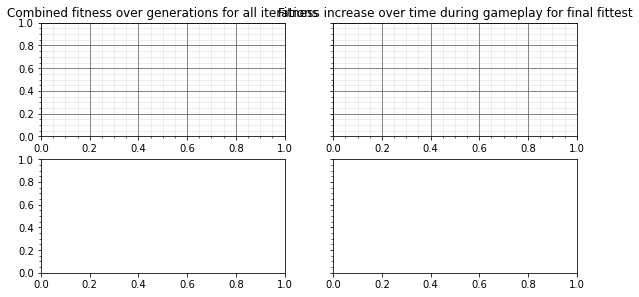

In [12]:
for b in bests1:
    print(b.decode)

runner1.produce_graph(gens1).show()

In [ ]:
bests1_2, gens1_2 = runner1.run_the_GA(1, True)

In [ ]:
for b in bests1_2:
    print(b.decode)

runner1.produce_graph(gens1_2)



In [ ]:
class TotesLegitSelfPlay(BaseChromosome):
    """I can assure you that these four agents are completely identical."""

    @classmethod
    def rules_list_A(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_FIVES,
            RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_R,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_9998,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_60,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_40,
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_ANY_USELESS_CARD_BELOW_MIN_PLAYED_RANK,
            RulesEnum.TELL_ANY_USELESS_CARD_ANY,
            RulesEnum.DISCARD_OLDEST_CARD,
            RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    @classmethod
    def rules_list_B(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.DISCARD_KNOWN_DISPOSABLE_CARD,
            RulesEnum.TELL_NEXT_MOST_COMMON_RANK,
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_NEXT_MOST_COMMON_COLOR,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    @classmethod
    def rules_list_C(cls) -> List[RulesEnum]:
        return [
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_ANY,
            RulesEnum.TELL_NEXT_OLDEST_CARD_C,
            RulesEnum.DISCARD_MOST_DISPOSABLE_CARD_80,
            RulesEnum.PLAY_MOST_PLAYABLE_LAST_HINTED_CARD_80,
            RulesEnum.PLAY_MOST_PLAYABLE_THRESH_80,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    @classmethod
    def rules_list_D(cls) -> List[RulesEnum]:
        return[
            RulesEnum.PLAY_HIGHEST_KNOWN_PLAYABLE,
            RulesEnum.DISCARD_KNOWN_USELESS_CARD,
            RulesEnum.PLAY_OLDEST_PREVIOUSLY_UNKNOWN_LAST_HINTED_CARD_80,
            RulesEnum.DISCARD_OLDEST_CARD,
            RulesEnum.TELL_ANY_ENDANGERED_CARD_ANY,
            RulesEnum.PLAY_LOWEST_KNOWN_PLAYABLE,
            RulesEnum.TELL_ANY_PLAYABLE_CARD_FULL_C,
            RulesEnum.TELL_ANY_ABOUT_ONES,
            RulesEnum.TELL_ANY_ABOUT_KNOWN_ONES_COLOR
        ]

    def __init__(self, a: Iterable[float] = None, b: List[float] = None, c: List[float] = None, d: List[float] = None):
        self._fitness: float = None
        self._results: GameResults = None

        if a is None:
            self._a: Tuple[float] = tuple(
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_A()
            )
        else:
            self._a = a
        if b is None:
            self._b : List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_B()
            ]
        else:
            self._b = b
        if c is None:
            self._c : List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_C()
            ]
        else:
            self._c = c
        if d is None:
            self._d : List[float] = [
                random.uniform(0.0, 1.0) for _ in TotesLegitSelfPlay.rules_list_D()
            ]
        else:
            self._d = d


    @property
    def chromosome(self) -> Dict[str,Tuple[float]]:
        return {
            "A": self._a,
            "B": self._b,
            "C": self._c,
            "D": self._d
        }

    def decode(self) -> str:
        return repr(self)

    @classmethod
    def generate_random(cls) -> "TotesLegitSelfPlay":
        return cls()

    @classmethod
    def crossover(cls, p1: "TotesLegitSelfPlay", p2: "TotesLegitSelfPlay") -> "TotesLegitSelfPlay":
        interp: float = random.random()

        return TotesLegitSelfPlay(tuple(
            p1._a[i] + ((p2._a[i] - p1._a[i]) * interp)
            for i in range(len(p1._a))
        ),
        tuple(
            p1._b[i] + ((p2._b[i] - p1._b[i]) * interp)
            for i in range(len(p1._b))
        ),
        tuple(
            p1._c[i] + ((p2._c[i] - p1._c[i]) * interp)
            for i in range(len(p1._c))
        ),
        tuple(
            p1._d[i] + ((p2._d[i] - p1._d[i]) * interp)
            for i in range(len(p1._d))
        )

        )

    @classmethod
    def mutate(cls, p1: TChromosome, mut_rate: float = 0.25) -> "TotesLegitSelfPlay":
        new_vectors: List[List[float]] = []
        for chr in (p1._a, p1._b, p1._c, p1._d):

            mutate_vector: List[float, ...] = [
                c + random.uniform(-mut_rate, mut_rate) for c in chr
            ]
            for i in range(len(mutate_vector)):
                if mutate_vector[i] > 1:
                    mutate_vector[i] -= 1
                elif mutate_vector[i] < 0:
                    mutate_vector[i] += 1
            new_vectors.append(mutate_vector)
        return cls(new_vectors[0],new_vectors[1],new_vectors[2],new_vectors[3])

    @classmethod
    def rules_list_priority_queue(cls, chromo: List[float], rlist: List[RulesEnum]) -> List[RulesEnum]:

        argsorted: np.ndarray = np.argsort(np.subtract(0, chromo))
        #cls.rules_list.copy()

        out_list: List[RulesEnum] = [rlist[ind] for ind in argsorted]
        return out_list

    def get_rules_and_parameters(self, info: ChromosomeInfo) -> AgentRules:
        if info.player_index == 0:
            return AgentRules(
                tuple(self.rules_list_priority_queue(self._a, TotesLegitSelfPlay.rules_list_A())),
                {}
            )
        elif  info.player_index == 1:
            return AgentRules(
                tuple(self.rules_list_priority_queue(self._b, TotesLegitSelfPlay.rules_list_B())),
                {}
            )
        elif  info.player_index == 2:
            return AgentRules(
                tuple(self.rules_list_priority_queue(self._c, TotesLegitSelfPlay.rules_list_C())),
                {}
            )
        elif  info.player_index == 3:
            return AgentRules(
                tuple(self.rules_list_priority_queue(self._d, TotesLegitSelfPlay.rules_list_D())),
                {}
            )
        else:
            raise RuntimeError(f'Unexpected player index of {info.player_index}')

In [ ]:
runner: GA_Runner = GA_Runner(TotesLegitSelfPlay)


In [ ]:
bests, gens = runner.run_the_GA(2, True)

In [ ]:
runner.produce_graph(gens)



